In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

seed = 42
np.random.seed(seed)
% matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.chdir('/content')
from google.colab import files
keys = files.upload()

Saving ssh.tar.gz to ssh.tar (1).gz


In [8]:
!rm -rf /root/.ssh
!mkdir /root/.ssh

!tar xvzf ssh.tar.gz

!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab
!chmod 700 /root/.ssh

!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/config
ssh-colab/id_rsa_colab
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-2de4da3d
# github.com:22 SSH-2.0-babeld-2de4da3d
# github.com:22 SSH-2.0-babeld-2de4da3d


In [10]:
!ssh-agent /bin/bash

bash: cannot set terminal process group (142): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@3149e49589c9: /contentroot@3149e49589c9:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (/root/.ssh/id_rsa_colab)
]0;root@3149e49589c9: /contentroot@3149e49589c9:/content# ssh-add -l
2048 SHA256:SpU/DuMOwLsZmS9hdQfImWud0o5YhuYTkxLgNOtF1aA /root/.ssh/id_rsa_colab (RSA)
]0;root@3149e49589c9: /contentroot@3149e49589c9:/content# exit
exit


In [0]:
!git config --global user.email 'rashmi.raviprasad@gmail.com'
!git config --global user.name 'rashmi-raviprasad'

In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES/NEW_FINAL_PICS'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [13]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, cat_dir, face_dir, n_images=1000):
    self.imgs = []
    cat_samples = np.random.choice(cat_dir, int(n_images/2), replace=False)
    face_samples = np.random.choice(face_dir, int(n_images/2), replace=False)
    all_samples = np.concatenate((cat_samples, face_samples))
    try:
      for file in tqdm(all_samples):
        fn = IMAGE_DIRECTORY + '/' + file
        img = cv2.imread(fn)
        rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    np.random.shuffle(self.imgs)
    x_all = np.arange(len(self.imgs))
    self.all_dim = np.asarray(self.imgs).shape[0]
    X = np.array(x_all)
    y = np.array(self.imgs)
    self.X = X
    self.y = y
    return X, y
  def build_model(self, n_components, model_filename, log_filename, n_dim=1000, decoder=None):
    os.chdir(REPOSITORY+'/faces_capstone2')
    decoder = Sequential()
    decoder.add(Embedding(input_dim=n_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    self.log_filename = log_filename
    train_log = pd.DataFrame(columns=['Date', 'Run_Number', 'Num_Epochs_Tot', 
                                      'Train_Loss', 'Valid_Loss'])
    init_data = {'Date':datetime.now(), 'Run_Number':0, 'Num_Epochs_Tot':0, 'Train_Loss':None, 
                 'Valid_Loss':None}
    train_log.loc[len(train_log)] = list(init_data.values())
    train_log.to_csv(self.log_filename, index=False)
  def fit_model(self, X, y, i, batch_size, n_epochs, n_pulls_tot):
    os.chdir(REPOSITORY+'/faces_capstone2')
    model = load_model(self.model_filename)
    model_hist = model.fit(X, y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(self.model_filename)
    train_log = pd.read_csv(self.log_filename)
    data_dict = {'Date':datetime.now(), 'Run_Number':i+1, 'Num_Epochs_Tot':n_epochs*(i+1), 
                 'Train_Loss':model_hist.history['loss'][-1], 'Valid_Loss':model_hist.history['val_loss'][-1]}
    train_log.loc[len(train_log)] = list(data_dict.values())
    train_log.to_csv(self.log_filename, index=False)
    self.pulls_remaining = n_pulls_tot - n_epochs*(i+1)
  def predict_model(self, X, y, model_filename, batch_size):
    os.chdir(REPOSITORY+'/faces_capstone2')
    self.decoder = load_model(model_filename)
    return self.decoder.predict(X, batch_size=batch_size)

Using TensorFlow backend.


In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  os.environ['MSG'] = commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [21]:
decoder_model = Decoder()
#decoder_model.load_data()

img_list = os.listdir(IMAGE_DIRECTORY)
cat_dir = []
face_dir = []
for filename in tqdm(img_list):
  if '_' in filename:
    cat_dir.append(filename)
  else:
    face_dir.append(filename)

print(len(cat_dir), len(face_dir))


100%|██████████| 56709/56709 [00:00<00:00, 2352808.13it/s]

9908 46801


In [22]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [23]:
BATCH_SIZE = 32 #make it like 32 or 64 or something
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 20
N_IMAGES = 200

decoder_model.build_model(N_COMPONENTS, 'test.h5', 'test.csv', n_dim=N_IMAGES)

In [0]:
from keras.models import load_model

#codeparade had 1769 images, augmented them to make 35,380 samples.
#he used 2000 epochs, so tot num of imgs seen by his network was 70,760,000.
#I am using pulls of 500 imgs and 20 epochs per pull. In order to
#match num of imgs seen by my network to his, I need to pull from the 
#dataset 7,076 times.

N_PULLS = 300
N_TOT_EPOCHS = N_EPOCHS * N_PULLS
N_PULLS_REMAINING = N_PULLS
for i in range(N_PULLS):
  print('Loading %d images' % N_IMAGES)
  X, y = decoder_model.load_data(cat_dir, face_dir, n_images=N_IMAGES)
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(X, y, i, BATCH_SIZE, N_EPOCHS, N_PULLS)
  message = 'trained %d of %d epochs' % (N_EPOCHS*(i+1), N_TOT_EPOCHS)
  message = message.replace(' ', '_')
  if i % 10 == 0:
    save_to_git(message)
  print('Trained %d epochs for total of %d epochs' % (N_EPOCHS, N_EPOCHS*(i+1)))


  0%|          | 0/200 [00:00<?, ?it/s]

Loading 200 images


100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


Training Batch # 1


Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 44ms/step - loss: 0.0746 - val_loss: 0.0795
Epoch 2/20
160/160 [==============================] - 0s 933us/step - loss: 0.0743 - val_loss: 0.0792
Epoch 3/20
160/160 [==============================] - 0s 865us/step - loss: 0.0740 - val_loss: 0.0788
Epoch 4/20
160/160 [==============================] - 0s 915us/step - loss: 0.0737 - val_loss: 0.0783
Epoch 5/20
160/160 [==============================] - 0s 938us/step - loss: 0.0733 - val_loss: 0.0777
Epoch 6/20
160/160 [==============================] - 0s 891us/step - loss: 0.0727 - val_loss: 0.0769
Epoch 7/20
160/160 [==============================] - 0s 908us/step - loss: 0.0720 - val_loss: 0.0758
Epoch 8/20
160/160 [==============================] - 0s 892us/step - loss: 0.0711 - val_loss: 0.0744
Epoch 9/20
160/160 [==============================] - 0s 884us/step - loss: 0.0701 - val_loss: 0.0732
Epoch 10/20
160/1

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 20 epochs
Loading 200 images


100%|██████████| 200/200 [01:07<00:00,  2.98it/s]


Training Batch # 2
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 4ms/step - loss: 0.0670 - val_loss: 0.0702
Epoch 2/20
160/160 [==============================] - 0s 956us/step - loss: 0.0667 - val_loss: 0.0714
Epoch 3/20
160/160 [==============================] - 0s 986us/step - loss: 0.0667 - val_loss: 0.0713
Epoch 4/20
160/160 [==============================] - 0s 939us/step - loss: 0.0665 - val_loss: 0.0712
Epoch 5/20
160/160 [==============================] - 0s 955us/step - loss: 0.0663 - val_loss: 0.0712
Epoch 6/20
160/160 [==============================] - 0s 930us/step - loss: 0.0658 - val_loss: 0.0718
Epoch 7/20
160/160 [==============================] - 0s 944us/step - loss: 0.0645 - val_loss: 0.0720
Epoch 8/20
160/160 [==============================] - 0s 930us/step - loss: 0.0624 - val_loss: 0.0707
Epoch 9/20
160/160 [==============================] - 0s 933us/step - loss: 0.0601 - val_loss: 0.0705
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 40 epochs
Loading 200 images


100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


Training Batch # 3
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0814 - val_loss: 0.0694
Epoch 2/20
160/160 [==============================] - 0s 941us/step - loss: 0.0679 - val_loss: 0.0636
Epoch 3/20
160/160 [==============================] - 0s 925us/step - loss: 0.0668 - val_loss: 0.0641
Epoch 4/20
160/160 [==============================] - 0s 919us/step - loss: 0.0641 - val_loss: 0.0630
Epoch 5/20
160/160 [==============================] - 0s 910us/step - loss: 0.0638 - val_loss: 0.0630
Epoch 6/20
160/160 [==============================] - 0s 892us/step - loss: 0.0625 - val_loss: 0.0624
Epoch 7/20
160/160 [==============================] - 0s 965us/step - loss: 0.0606 - val_loss: 0.0632
Epoch 8/20
160/160 [==============================] - 0s 935us/step - loss: 0.0579 - val_loss: 0.0621
Epoch 9/20
160/160 [==============================] - 0s 889us/step - loss: 0.0540 - val_loss: 0.0621
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 60 epochs
Loading 200 images


100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


Training Batch # 4
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 5ms/step - loss: 0.0855 - val_loss: 0.0740
Epoch 2/20
160/160 [==============================] - 0s 935us/step - loss: 0.0677 - val_loss: 0.0717
Epoch 3/20
160/160 [==============================] - 0s 934us/step - loss: 0.0643 - val_loss: 0.0746
Epoch 4/20
160/160 [==============================] - 0s 907us/step - loss: 0.0646 - val_loss: 0.0744
Epoch 5/20
160/160 [==============================] - 0s 938us/step - loss: 0.0634 - val_loss: 0.0724
Epoch 6/20
160/160 [==============================] - 0s 926us/step - loss: 0.0622 - val_loss: 0.0719
Epoch 7/20
160/160 [==============================] - 0s 913us/step - loss: 0.0604 - val_loss: 0.0736
Epoch 8/20
160/160 [==============================] - 0s 901us/step - loss: 0.0580 - val_loss: 0.0762
Epoch 9/20
160/160 [==============================] - 0s 930us/step - loss: 0.0553 - val_loss: 0.0767
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 80 epochs
Loading 200 images


100%|██████████| 200/200 [00:43<00:00,  4.57it/s]


Training Batch # 5
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0815 - val_loss: 0.0704
Epoch 2/20
160/160 [==============================] - 0s 957us/step - loss: 0.0656 - val_loss: 0.0658
Epoch 3/20
160/160 [==============================] - 0s 945us/step - loss: 0.0612 - val_loss: 0.0636
Epoch 4/20
160/160 [==============================] - 0s 940us/step - loss: 0.0606 - val_loss: 0.0638
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0642
Epoch 6/20
160/160 [==============================] - 0s 927us/step - loss: 0.0576 - val_loss: 0.0632
Epoch 7/20
160/160 [==============================] - 0s 912us/step - loss: 0.0553 - val_loss: 0.0620
Epoch 8/20
160/160 [==============================] - 0s 944us/step - loss: 0.0527 - val_loss: 0.0625
Epoch 9/20
160/160 [==============================] - 0s 956us/step - loss: 0.0497 - val_loss: 0.0638
Epoch 10/20
160/160 [=

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 100 epochs
Loading 200 images


100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


Training Batch # 6
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 6ms/step - loss: 0.0876 - val_loss: 0.0635
Epoch 2/20
160/160 [==============================] - 0s 953us/step - loss: 0.0712 - val_loss: 0.0604
Epoch 3/20
160/160 [==============================] - 0s 928us/step - loss: 0.0648 - val_loss: 0.0597
Epoch 4/20
160/160 [==============================] - 0s 913us/step - loss: 0.0632 - val_loss: 0.0593
Epoch 5/20
160/160 [==============================] - 0s 912us/step - loss: 0.0620 - val_loss: 0.0589
Epoch 6/20
160/160 [==============================] - 0s 924us/step - loss: 0.0605 - val_loss: 0.0584
Epoch 7/20
160/160 [==============================] - 0s 948us/step - loss: 0.0582 - val_loss: 0.0584
Epoch 8/20
160/160 [==============================] - 0s 980us/step - loss: 0.0558 - val_loss: 0.0587
Epoch 9/20
160/160 [==============================] - 0s 924us/step - loss: 0.0530 - val_loss: 0.0593
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 120 epochs
Loading 200 images


100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


Training Batch # 7
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 7ms/step - loss: 0.0888 - val_loss: 0.0843
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 0.0763
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0684
Epoch 4/20
160/160 [==============================] - 0s 961us/step - loss: 0.0641 - val_loss: 0.0680
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0704
Epoch 6/20
160/160 [==============================] - 0s 956us/step - loss: 0.0605 - val_loss: 0.0704
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0690
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0555 - val_loss: 0.0699
Epoch 9/20
160/160 [==============================] - 0s 993us/step - loss: 0.0528 - val_loss: 0.0727
Epoch 10/20
160/160 [=========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 140 epochs
Loading 200 images


100%|██████████| 200/200 [00:42<00:00,  4.73it/s]


Training Batch # 8
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 8ms/step - loss: 0.0914 - val_loss: 0.0813
Epoch 2/20
160/160 [==============================] - 0s 1000us/step - loss: 0.0712 - val_loss: 0.0762
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0720
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0718
Epoch 5/20
160/160 [==============================] - 0s 976us/step - loss: 0.0621 - val_loss: 0.0729
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0722
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0719
Epoch 8/20
160/160 [==============================] - 0s 990us/step - loss: 0.0565 - val_loss: 0.0730
Epoch 9/20
160/160 [==============================] - 0s 982us/step - loss: 0.0544 - val_loss: 0.0738
Epoch 10/20
160/160 [======

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 160 epochs
Loading 200 images


100%|██████████| 200/200 [00:41<00:00,  4.77it/s]


Training Batch # 9
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 9ms/step - loss: 0.0898 - val_loss: 0.0646
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0658
Epoch 3/20
160/160 [==============================] - 0s 985us/step - loss: 0.0644 - val_loss: 0.0692
Epoch 4/20
160/160 [==============================] - 0s 998us/step - loss: 0.0632 - val_loss: 0.0664
Epoch 5/20
160/160 [==============================] - 0s 995us/step - loss: 0.0621 - val_loss: 0.0662
Epoch 6/20
160/160 [==============================] - 0s 966us/step - loss: 0.0609 - val_loss: 0.0681
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0681
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0678
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0557 - val_loss: 0.0694
Epoch 10/20
160/160 [=======

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 180 epochs
Loading 200 images


100%|██████████| 200/200 [00:41<00:00,  4.82it/s]


Training Batch # 10
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 1s 9ms/step - loss: 0.0892 - val_loss: 0.0715
Epoch 2/20
160/160 [==============================] - 0s 949us/step - loss: 0.0725 - val_loss: 0.0731
Epoch 3/20
160/160 [==============================] - 0s 948us/step - loss: 0.0647 - val_loss: 0.0785
Epoch 4/20
160/160 [==============================] - 0s 937us/step - loss: 0.0620 - val_loss: 0.0708
Epoch 5/20
160/160 [==============================] - 0s 907us/step - loss: 0.0603 - val_loss: 0.0701
Epoch 6/20
160/160 [==============================] - 0s 903us/step - loss: 0.0582 - val_loss: 0.0719
Epoch 7/20
160/160 [==============================] - 0s 934us/step - loss: 0.0561 - val_loss: 0.0740
Epoch 8/20
160/160 [==============================] - 0s 983us/step - loss: 0.0533 - val_loss: 0.0719
Epoch 9/20
160/160 [==============================] - 0s 939us/step - loss: 0.0505 - val_loss: 0.0715
Epoch 10/20
160/160

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 200 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


Training Batch # 11
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 9ms/step - loss: 0.0924 - val_loss: 0.0754
Epoch 2/20
160/160 [==============================] - 0s 948us/step - loss: 0.0744 - val_loss: 0.0702
Epoch 3/20
160/160 [==============================] - 0s 922us/step - loss: 0.0650 - val_loss: 0.0696
Epoch 4/20
160/160 [==============================] - 0s 906us/step - loss: 0.0622 - val_loss: 0.0692
Epoch 5/20
160/160 [==============================] - 0s 934us/step - loss: 0.0607 - val_loss: 0.0676
Epoch 6/20
160/160 [==============================] - 0s 940us/step - loss: 0.0594 - val_loss: 0.0672
Epoch 7/20
160/160 [==============================] - 0s 915us/step - loss: 0.0580 - val_loss: 0.0678
Epoch 8/20
160/160 [==============================] - 0s 890us/step - loss: 0.0558 - val_loss: 0.0689
Epoch 9/20
160/160 [==============================] - 0s 937us/step - loss: 0.0537 - val_loss: 0.0698
Epoch 10/20
160/160

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 220 epochs
Loading 200 images


100%|██████████| 200/200 [00:39<00:00,  5.01it/s]


Training Batch # 12
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 10ms/step - loss: 0.0926 - val_loss: 0.0665
Epoch 2/20
160/160 [==============================] - 0s 951us/step - loss: 0.0753 - val_loss: 0.0667
Epoch 3/20
160/160 [==============================] - 0s 965us/step - loss: 0.0657 - val_loss: 0.0699
Epoch 4/20
160/160 [==============================] - 0s 931us/step - loss: 0.0629 - val_loss: 0.0664
Epoch 5/20
160/160 [==============================] - 0s 927us/step - loss: 0.0610 - val_loss: 0.0658
Epoch 6/20
160/160 [==============================] - 0s 925us/step - loss: 0.0591 - val_loss: 0.0670
Epoch 7/20
160/160 [==============================] - 0s 882us/step - loss: 0.0567 - val_loss: 0.0695
Epoch 8/20
160/160 [==============================] - 0s 944us/step - loss: 0.0541 - val_loss: 0.0719
Epoch 9/20
160/160 [==============================] - 0s 947us/step - loss: 0.0512 - val_loss: 0.0742
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 240 epochs
Loading 200 images


100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


Training Batch # 13
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 10ms/step - loss: 0.0883 - val_loss: 0.0779
Epoch 2/20
160/160 [==============================] - 0s 954us/step - loss: 0.0727 - val_loss: 0.0736
Epoch 3/20
160/160 [==============================] - 0s 896us/step - loss: 0.0622 - val_loss: 0.0799
Epoch 4/20
160/160 [==============================] - 0s 873us/step - loss: 0.0595 - val_loss: 0.0753
Epoch 5/20
160/160 [==============================] - 0s 911us/step - loss: 0.0572 - val_loss: 0.0699
Epoch 6/20
160/160 [==============================] - 0s 894us/step - loss: 0.0556 - val_loss: 0.0727
Epoch 7/20
160/160 [==============================] - 0s 867us/step - loss: 0.0530 - val_loss: 0.0778
Epoch 8/20
160/160 [==============================] - 0s 919us/step - loss: 0.0508 - val_loss: 0.0825
Epoch 9/20
160/160 [==============================] - 0s 895us/step - loss: 0.0483 - val_loss: 0.0816
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 260 epochs
Loading 200 images


100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


Training Batch # 14
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 11ms/step - loss: 0.0934 - val_loss: 0.0763
Epoch 2/20
160/160 [==============================] - 0s 952us/step - loss: 0.0780 - val_loss: 0.0713
Epoch 3/20
160/160 [==============================] - 0s 934us/step - loss: 0.0697 - val_loss: 0.0729
Epoch 4/20
160/160 [==============================] - 0s 948us/step - loss: 0.0655 - val_loss: 0.0700
Epoch 5/20
160/160 [==============================] - 0s 917us/step - loss: 0.0633 - val_loss: 0.0721
Epoch 6/20
160/160 [==============================] - 0s 941us/step - loss: 0.0609 - val_loss: 0.0741
Epoch 7/20
160/160 [==============================] - 0s 902us/step - loss: 0.0583 - val_loss: 0.0739
Epoch 8/20
160/160 [==============================] - 0s 933us/step - loss: 0.0554 - val_loss: 0.0747
Epoch 9/20
160/160 [==============================] - 0s 924us/step - loss: 0.0526 - val_loss: 0.0779
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 280 epochs
Loading 200 images


100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Training Batch # 15
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 12ms/step - loss: 0.0963 - val_loss: 0.0765
Epoch 2/20
160/160 [==============================] - 0s 956us/step - loss: 0.0741 - val_loss: 0.0710
Epoch 3/20
160/160 [==============================] - 0s 941us/step - loss: 0.0643 - val_loss: 0.0712
Epoch 4/20
160/160 [==============================] - 0s 941us/step - loss: 0.0620 - val_loss: 0.0703
Epoch 5/20
160/160 [==============================] - 0s 932us/step - loss: 0.0598 - val_loss: 0.0692
Epoch 6/20
160/160 [==============================] - 0s 928us/step - loss: 0.0562 - val_loss: 0.0727
Epoch 7/20
160/160 [==============================] - 0s 960us/step - loss: 0.0530 - val_loss: 0.0759
Epoch 8/20
160/160 [==============================] - 0s 935us/step - loss: 0.0496 - val_loss: 0.0746
Epoch 9/20
160/160 [==============================] - 0s 920us/step - loss: 0.0467 - val_loss: 0.0788
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 300 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


Training Batch # 16
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 12ms/step - loss: 0.0986 - val_loss: 0.0730
Epoch 2/20
160/160 [==============================] - 0s 931us/step - loss: 0.0776 - val_loss: 0.0689
Epoch 3/20
160/160 [==============================] - 0s 923us/step - loss: 0.0675 - val_loss: 0.0701
Epoch 4/20
160/160 [==============================] - 0s 914us/step - loss: 0.0648 - val_loss: 0.0706
Epoch 5/20
160/160 [==============================] - 0s 919us/step - loss: 0.0627 - val_loss: 0.0669
Epoch 6/20
160/160 [==============================] - 0s 950us/step - loss: 0.0609 - val_loss: 0.0661
Epoch 7/20
160/160 [==============================] - 0s 898us/step - loss: 0.0590 - val_loss: 0.0675
Epoch 8/20
160/160 [==============================] - 0s 899us/step - loss: 0.0565 - val_loss: 0.0689
Epoch 9/20
160/160 [==============================] - 0s 910us/step - loss: 0.0540 - val_loss: 0.0688
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 320 epochs
Loading 200 images


100%|██████████| 200/200 [00:42<00:00,  4.69it/s]


Training Batch # 17
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 13ms/step - loss: 0.0900 - val_loss: 0.0674
Epoch 2/20
160/160 [==============================] - 0s 937us/step - loss: 0.0761 - val_loss: 0.0654
Epoch 3/20
160/160 [==============================] - 0s 930us/step - loss: 0.0651 - val_loss: 0.0703
Epoch 4/20
160/160 [==============================] - 0s 914us/step - loss: 0.0613 - val_loss: 0.0723
Epoch 5/20
160/160 [==============================] - 0s 968us/step - loss: 0.0591 - val_loss: 0.0669
Epoch 6/20
160/160 [==============================] - 0s 954us/step - loss: 0.0574 - val_loss: 0.0654
Epoch 7/20
160/160 [==============================] - 0s 947us/step - loss: 0.0559 - val_loss: 0.0675
Epoch 8/20
160/160 [==============================] - 0s 910us/step - loss: 0.0539 - val_loss: 0.0706
Epoch 9/20
160/160 [==============================] - 0s 930us/step - loss: 0.0521 - val_loss: 0.0696
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:37,  5.37it/s]

Trained 20 epochs for total of 340 epochs
Loading 200 images


100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


Training Batch # 18
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 14ms/step - loss: 0.0896 - val_loss: 0.0719
Epoch 2/20
160/160 [==============================] - 0s 971us/step - loss: 0.0758 - val_loss: 0.0703
Epoch 3/20
160/160 [==============================] - 0s 906us/step - loss: 0.0658 - val_loss: 0.0769
Epoch 4/20
160/160 [==============================] - 0s 936us/step - loss: 0.0617 - val_loss: 0.0738
Epoch 5/20
160/160 [==============================] - 0s 890us/step - loss: 0.0590 - val_loss: 0.0719
Epoch 6/20
160/160 [==============================] - 0s 912us/step - loss: 0.0570 - val_loss: 0.0727
Epoch 7/20
160/160 [==============================] - 0s 910us/step - loss: 0.0547 - val_loss: 0.0774
Epoch 8/20
160/160 [==============================] - 0s 957us/step - loss: 0.0526 - val_loss: 0.0791
Epoch 9/20
160/160 [==============================] - 0s 929us/step - loss: 0.0499 - val_loss: 0.0788
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 360 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


Training Batch # 19
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 14ms/step - loss: 0.0875 - val_loss: 0.0669
Epoch 2/20
160/160 [==============================] - 0s 934us/step - loss: 0.0751 - val_loss: 0.0658
Epoch 3/20
160/160 [==============================] - 0s 934us/step - loss: 0.0635 - val_loss: 0.0774
Epoch 4/20
160/160 [==============================] - 0s 908us/step - loss: 0.0602 - val_loss: 0.0723
Epoch 5/20
160/160 [==============================] - 0s 918us/step - loss: 0.0570 - val_loss: 0.0652
Epoch 6/20
160/160 [==============================] - 0s 947us/step - loss: 0.0553 - val_loss: 0.0676
Epoch 7/20
160/160 [==============================] - 0s 952us/step - loss: 0.0529 - val_loss: 0.0723
Epoch 8/20
160/160 [==============================] - 0s 951us/step - loss: 0.0509 - val_loss: 0.0728
Epoch 9/20
160/160 [==============================] - 0s 906us/step - loss: 0.0486 - val_loss: 0.0712
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:35,  5.61it/s]

Trained 20 epochs for total of 380 epochs
Loading 200 images


100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


Training Batch # 20
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 2s 15ms/step - loss: 0.0859 - val_loss: 0.0724
Epoch 2/20
160/160 [==============================] - 0s 963us/step - loss: 0.0748 - val_loss: 0.0701
Epoch 3/20
160/160 [==============================] - 0s 947us/step - loss: 0.0626 - val_loss: 0.0686
Epoch 4/20
160/160 [==============================] - 0s 951us/step - loss: 0.0593 - val_loss: 0.0674
Epoch 5/20
160/160 [==============================] - 0s 933us/step - loss: 0.0554 - val_loss: 0.0654
Epoch 6/20
160/160 [==============================] - 0s 967us/step - loss: 0.0536 - val_loss: 0.0653
Epoch 7/20
160/160 [==============================] - 0s 944us/step - loss: 0.0511 - val_loss: 0.0667
Epoch 8/20
160/160 [==============================] - 0s 924us/step - loss: 0.0488 - val_loss: 0.0666
Epoch 9/20
160/160 [==============================] - 0s 940us/step - loss: 0.0462 - val_loss: 0.0667
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 400 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


Training Batch # 21
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 16ms/step - loss: 0.0911 - val_loss: 0.0743
Epoch 2/20
160/160 [==============================] - 0s 980us/step - loss: 0.0763 - val_loss: 0.0718
Epoch 3/20
160/160 [==============================] - 0s 968us/step - loss: 0.0649 - val_loss: 0.0795
Epoch 4/20
160/160 [==============================] - 0s 956us/step - loss: 0.0607 - val_loss: 0.0755
Epoch 5/20
160/160 [==============================] - 0s 954us/step - loss: 0.0573 - val_loss: 0.0725
Epoch 6/20
160/160 [==============================] - 0s 936us/step - loss: 0.0546 - val_loss: 0.0747
Epoch 7/20
160/160 [==============================] - 0s 949us/step - loss: 0.0519 - val_loss: 0.0756
Epoch 8/20
160/160 [==============================] - 0s 946us/step - loss: 0.0491 - val_loss: 0.0743
Epoch 9/20
160/160 [==============================] - 0s 964us/step - loss: 0.0461 - val_loss: 0.0775
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:33,  6.00it/s]

Trained 20 epochs for total of 420 epochs
Loading 200 images


100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Training Batch # 22
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 16ms/step - loss: 0.0950 - val_loss: 0.0669
Epoch 2/20
160/160 [==============================] - 0s 947us/step - loss: 0.0804 - val_loss: 0.0586
Epoch 3/20
160/160 [==============================] - 0s 929us/step - loss: 0.0676 - val_loss: 0.0603
Epoch 4/20
160/160 [==============================] - 0s 910us/step - loss: 0.0635 - val_loss: 0.0591
Epoch 5/20
160/160 [==============================] - 0s 908us/step - loss: 0.0596 - val_loss: 0.0557
Epoch 6/20
160/160 [==============================] - 0s 898us/step - loss: 0.0573 - val_loss: 0.0556
Epoch 7/20
160/160 [==============================] - 0s 915us/step - loss: 0.0545 - val_loss: 0.0566
Epoch 8/20
160/160 [==============================] - 0s 918us/step - loss: 0.0521 - val_loss: 0.0559
Epoch 9/20
160/160 [==============================] - 0s 920us/step - loss: 0.0491 - val_loss: 0.0560
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 440 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.58it/s]


Training Batch # 23
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 17ms/step - loss: 0.0880 - val_loss: 0.0729
Epoch 2/20
160/160 [==============================] - 0s 930us/step - loss: 0.0747 - val_loss: 0.0650
Epoch 3/20
160/160 [==============================] - 0s 937us/step - loss: 0.0636 - val_loss: 0.0676
Epoch 4/20
160/160 [==============================] - 0s 890us/step - loss: 0.0581 - val_loss: 0.0634
Epoch 5/20
160/160 [==============================] - 0s 939us/step - loss: 0.0544 - val_loss: 0.0629
Epoch 6/20
160/160 [==============================] - 0s 912us/step - loss: 0.0515 - val_loss: 0.0649
Epoch 7/20
160/160 [==============================] - 0s 922us/step - loss: 0.0489 - val_loss: 0.0629
Epoch 8/20
160/160 [==============================] - 0s 934us/step - loss: 0.0465 - val_loss: 0.0626
Epoch 9/20
160/160 [==============================] - 0s 922us/step - loss: 0.0439 - val_loss: 0.0635
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 460 epochs
Loading 200 images


100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


Training Batch # 24
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 18ms/step - loss: 0.0906 - val_loss: 0.0790
Epoch 2/20
160/160 [==============================] - 0s 936us/step - loss: 0.0760 - val_loss: 0.0712
Epoch 3/20
160/160 [==============================] - 0s 950us/step - loss: 0.0655 - val_loss: 0.0724
Epoch 4/20
160/160 [==============================] - 0s 931us/step - loss: 0.0613 - val_loss: 0.0714
Epoch 5/20
160/160 [==============================] - 0s 930us/step - loss: 0.0582 - val_loss: 0.0703
Epoch 6/20
160/160 [==============================] - 0s 920us/step - loss: 0.0559 - val_loss: 0.0705
Epoch 7/20
160/160 [==============================] - 0s 927us/step - loss: 0.0532 - val_loss: 0.0715
Epoch 8/20
160/160 [==============================] - 0s 946us/step - loss: 0.0504 - val_loss: 0.0701
Epoch 9/20
160/160 [==============================] - 0s 909us/step - loss: 0.0474 - val_loss: 0.0696
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:29,  6.66it/s]

Trained 20 epochs for total of 480 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.41it/s]


Training Batch # 25
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 19ms/step - loss: 0.0916 - val_loss: 0.0946
Epoch 2/20
160/160 [==============================] - 0s 952us/step - loss: 0.0772 - val_loss: 0.0892
Epoch 3/20
160/160 [==============================] - 0s 969us/step - loss: 0.0669 - val_loss: 0.0772
Epoch 4/20
160/160 [==============================] - 0s 960us/step - loss: 0.0614 - val_loss: 0.0774
Epoch 5/20
160/160 [==============================] - 0s 947us/step - loss: 0.0583 - val_loss: 0.0753
Epoch 6/20
160/160 [==============================] - 0s 930us/step - loss: 0.0558 - val_loss: 0.0752
Epoch 7/20
160/160 [==============================] - 0s 914us/step - loss: 0.0536 - val_loss: 0.0756
Epoch 8/20
160/160 [==============================] - 0s 948us/step - loss: 0.0513 - val_loss: 0.0766
Epoch 9/20
160/160 [==============================] - 0s 932us/step - loss: 0.0490 - val_loss: 0.0762
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 500 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


Training Batch # 26
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 20ms/step - loss: 0.0915 - val_loss: 0.0713
Epoch 2/20
160/160 [==============================] - 0s 972us/step - loss: 0.0782 - val_loss: 0.0673
Epoch 3/20
160/160 [==============================] - 0s 980us/step - loss: 0.0671 - val_loss: 0.0644
Epoch 4/20
160/160 [==============================] - 0s 911us/step - loss: 0.0618 - val_loss: 0.0642
Epoch 5/20
160/160 [==============================] - 0s 934us/step - loss: 0.0577 - val_loss: 0.0629
Epoch 6/20
160/160 [==============================] - 0s 940us/step - loss: 0.0550 - val_loss: 0.0637
Epoch 7/20
160/160 [==============================] - 0s 933us/step - loss: 0.0522 - val_loss: 0.0651
Epoch 8/20
160/160 [==============================] - 0s 929us/step - loss: 0.0495 - val_loss: 0.0661
Epoch 9/20
160/160 [==============================] - 0s 940us/step - loss: 0.0468 - val_loss: 0.0655
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:36,  5.52it/s]

Trained 20 epochs for total of 520 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.26it/s]


Training Batch # 27
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 21ms/step - loss: 0.0980 - val_loss: 0.0806
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0850 - val_loss: 0.0757
Epoch 3/20
160/160 [==============================] - 0s 980us/step - loss: 0.0734 - val_loss: 0.0704
Epoch 4/20
160/160 [==============================] - 0s 954us/step - loss: 0.0678 - val_loss: 0.0700
Epoch 5/20
160/160 [==============================] - 0s 959us/step - loss: 0.0636 - val_loss: 0.0685
Epoch 6/20
160/160 [==============================] - 0s 978us/step - loss: 0.0610 - val_loss: 0.0689
Epoch 7/20
160/160 [==============================] - 0s 952us/step - loss: 0.0576 - val_loss: 0.0699
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0547 - val_loss: 0.0695
Epoch 9/20
160/160 [==============================] - 0s 970us/step - loss: 0.0518 - val_loss: 0.0695
Epoch 10/20
160/160 [=

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 540 epochs
Loading 200 images


100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Training Batch # 28
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 3s 21ms/step - loss: 0.0919 - val_loss: 0.0681
Epoch 2/20
160/160 [==============================] - 0s 981us/step - loss: 0.0781 - val_loss: 0.0661
Epoch 3/20
160/160 [==============================] - 0s 994us/step - loss: 0.0680 - val_loss: 0.0604
Epoch 4/20
160/160 [==============================] - 0s 987us/step - loss: 0.0613 - val_loss: 0.0682
Epoch 5/20
160/160 [==============================] - 0s 975us/step - loss: 0.0577 - val_loss: 0.0610
Epoch 6/20
160/160 [==============================] - 0s 949us/step - loss: 0.0546 - val_loss: 0.0601
Epoch 7/20
160/160 [==============================] - 0s 965us/step - loss: 0.0523 - val_loss: 0.0627
Epoch 8/20
160/160 [==============================] - 0s 928us/step - loss: 0.0498 - val_loss: 0.0641
Epoch 9/20
160/160 [==============================] - 0s 932us/step - loss: 0.0473 - val_loss: 0.0626
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 560 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


Training Batch # 29
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 22ms/step - loss: 0.0907 - val_loss: 0.0717
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0803 - val_loss: 0.0705
Epoch 3/20
160/160 [==============================] - 0s 955us/step - loss: 0.0714 - val_loss: 0.0679
Epoch 4/20
160/160 [==============================] - 0s 943us/step - loss: 0.0642 - val_loss: 0.0751
Epoch 5/20
160/160 [==============================] - 0s 958us/step - loss: 0.0607 - val_loss: 0.0706
Epoch 6/20
160/160 [==============================] - 0s 975us/step - loss: 0.0575 - val_loss: 0.0680
Epoch 7/20
160/160 [==============================] - 0s 976us/step - loss: 0.0552 - val_loss: 0.0709
Epoch 8/20
160/160 [==============================] - 0s 999us/step - loss: 0.0526 - val_loss: 0.0744
Epoch 9/20
160/160 [==============================] - 0s 978us/step - loss: 0.0503 - val_loss: 0.0717
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 580 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


Training Batch # 30
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 23ms/step - loss: 0.0896 - val_loss: 0.0791
Epoch 2/20
160/160 [==============================] - 0s 986us/step - loss: 0.0787 - val_loss: 0.0792
Epoch 3/20
160/160 [==============================] - 0s 982us/step - loss: 0.0703 - val_loss: 0.0715
Epoch 4/20
160/160 [==============================] - 0s 975us/step - loss: 0.0631 - val_loss: 0.0750
Epoch 5/20
160/160 [==============================] - 0s 942us/step - loss: 0.0594 - val_loss: 0.0706
Epoch 6/20
160/160 [==============================] - 0s 950us/step - loss: 0.0561 - val_loss: 0.0701
Epoch 7/20
160/160 [==============================] - 0s 960us/step - loss: 0.0535 - val_loss: 0.0719
Epoch 8/20
160/160 [==============================] - 0s 960us/step - loss: 0.0508 - val_loss: 0.0720
Epoch 9/20
160/160 [==============================] - 0s 963us/step - loss: 0.0484 - val_loss: 0.0712
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 600 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


Training Batch # 31
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 23ms/step - loss: 0.0925 - val_loss: 0.0791
Epoch 2/20
160/160 [==============================] - 0s 946us/step - loss: 0.0794 - val_loss: 0.0776
Epoch 3/20
160/160 [==============================] - 0s 953us/step - loss: 0.0703 - val_loss: 0.0670
Epoch 4/20
160/160 [==============================] - 0s 950us/step - loss: 0.0631 - val_loss: 0.0687
Epoch 5/20
160/160 [==============================] - 0s 951us/step - loss: 0.0586 - val_loss: 0.0659
Epoch 6/20
160/160 [==============================] - 0s 961us/step - loss: 0.0554 - val_loss: 0.0656
Epoch 7/20
160/160 [==============================] - 0s 930us/step - loss: 0.0523 - val_loss: 0.0660
Epoch 8/20
160/160 [==============================] - 0s 926us/step - loss: 0.0496 - val_loss: 0.0658
Epoch 9/20
160/160 [==============================] - 0s 916us/step - loss: 0.0468 - val_loss: 0.0663
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 620 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Training Batch # 32
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 24ms/step - loss: 0.0895 - val_loss: 0.0799
Epoch 2/20
160/160 [==============================] - 0s 946us/step - loss: 0.0778 - val_loss: 0.0777
Epoch 3/20
160/160 [==============================] - 0s 913us/step - loss: 0.0680 - val_loss: 0.0663
Epoch 4/20
160/160 [==============================] - 0s 906us/step - loss: 0.0614 - val_loss: 0.0659
Epoch 5/20
160/160 [==============================] - 0s 950us/step - loss: 0.0577 - val_loss: 0.0652
Epoch 6/20
160/160 [==============================] - 0s 913us/step - loss: 0.0549 - val_loss: 0.0652
Epoch 7/20
160/160 [==============================] - 0s 919us/step - loss: 0.0524 - val_loss: 0.0650
Epoch 8/20
160/160 [==============================] - 0s 909us/step - loss: 0.0502 - val_loss: 0.0651
Epoch 9/20
160/160 [==============================] - 0s 920us/step - loss: 0.0478 - val_loss: 0.0655
Epoch 10/20
160/16

  0%|          | 1/200 [00:00<00:35,  5.56it/s]

Trained 20 epochs for total of 640 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.42it/s]


Training Batch # 33
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 25ms/step - loss: 0.0921 - val_loss: 0.0881
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0796 - val_loss: 0.0803
Epoch 3/20
160/160 [==============================] - 0s 934us/step - loss: 0.0685 - val_loss: 0.0725
Epoch 4/20
160/160 [==============================] - 0s 959us/step - loss: 0.0636 - val_loss: 0.0718
Epoch 5/20
160/160 [==============================] - 0s 962us/step - loss: 0.0589 - val_loss: 0.0711
Epoch 6/20
160/160 [==============================] - 0s 952us/step - loss: 0.0562 - val_loss: 0.0714
Epoch 7/20
160/160 [==============================] - 0s 892us/step - loss: 0.0529 - val_loss: 0.0734
Epoch 8/20
160/160 [==============================] - 0s 914us/step - loss: 0.0502 - val_loss: 0.0736
Epoch 9/20
160/160 [==============================] - 0s 1000us/step - loss: 0.0473 - val_loss: 0.0739
Epoch 10/20
160/160

  0%|          | 1/200 [00:00<00:35,  5.57it/s]

Trained 20 epochs for total of 660 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.54it/s]


Training Batch # 34
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 27ms/step - loss: 0.0850 - val_loss: 0.0853
Epoch 2/20
160/160 [==============================] - 0s 985us/step - loss: 0.0735 - val_loss: 0.0821
Epoch 3/20
160/160 [==============================] - 0s 985us/step - loss: 0.0635 - val_loss: 0.0701
Epoch 4/20
160/160 [==============================] - 0s 983us/step - loss: 0.0589 - val_loss: 0.0697
Epoch 5/20
160/160 [==============================] - 0s 982us/step - loss: 0.0548 - val_loss: 0.0686
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0526 - val_loss: 0.0685
Epoch 7/20
160/160 [==============================] - 0s 980us/step - loss: 0.0495 - val_loss: 0.0688
Epoch 8/20
160/160 [==============================] - 0s 973us/step - loss: 0.0475 - val_loss: 0.0690
Epoch 9/20
160/160 [==============================] - 0s 982us/step - loss: 0.0450 - val_loss: 0.0694
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 680 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.43it/s]


Training Batch # 35
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 4s 27ms/step - loss: 0.0891 - val_loss: 0.0752
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0773 - val_loss: 0.0730
Epoch 3/20
160/160 [==============================] - 0s 972us/step - loss: 0.0669 - val_loss: 0.0678
Epoch 4/20
160/160 [==============================] - 0s 947us/step - loss: 0.0613 - val_loss: 0.0705
Epoch 5/20
160/160 [==============================] - 0s 962us/step - loss: 0.0579 - val_loss: 0.0665
Epoch 6/20
160/160 [==============================] - 0s 952us/step - loss: 0.0549 - val_loss: 0.0665
Epoch 7/20
160/160 [==============================] - 0s 946us/step - loss: 0.0524 - val_loss: 0.0682
Epoch 8/20
160/160 [==============================] - 0s 955us/step - loss: 0.0498 - val_loss: 0.0682
Epoch 9/20
160/160 [==============================] - 0s 985us/step - loss: 0.0472 - val_loss: 0.0691
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 700 epochs
Loading 200 images


100%|██████████| 200/200 [00:42<00:00,  4.76it/s]


Training Batch # 36
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 29ms/step - loss: 0.0926 - val_loss: 0.0702
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0792 - val_loss: 0.0685
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0693
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0725
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0671
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0662
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0538 - val_loss: 0.0715
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0506 - val_loss: 0.0708
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0474 - val_loss: 0.0697
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 720 epochs
Loading 200 images


100%|██████████| 200/200 [00:41<00:00,  4.81it/s]


Training Batch # 37
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 29ms/step - loss: 0.0915 - val_loss: 0.0713
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0774 - val_loss: 0.0684
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0723
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0799
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0573 - val_loss: 0.0709
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0549 - val_loss: 0.0697
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 0.0773
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0498 - val_loss: 0.0806
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0472 - val_loss: 0.0754
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 740 epochs
Loading 200 images


100%|██████████| 200/200 [00:37<00:00,  5.40it/s]


Training Batch # 38
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 29ms/step - loss: 0.0886 - val_loss: 0.0746
Epoch 2/20
160/160 [==============================] - 0s 971us/step - loss: 0.0754 - val_loss: 0.0768
Epoch 3/20
160/160 [==============================] - 0s 949us/step - loss: 0.0661 - val_loss: 0.0698
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0736
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0561 - val_loss: 0.0698
Epoch 6/20
160/160 [==============================] - 0s 976us/step - loss: 0.0530 - val_loss: 0.0686
Epoch 7/20
160/160 [==============================] - 0s 922us/step - loss: 0.0510 - val_loss: 0.0693
Epoch 8/20
160/160 [==============================] - 0s 979us/step - loss: 0.0486 - val_loss: 0.0711
Epoch 9/20
160/160 [==============================] - 0s 936us/step - loss: 0.0468 - val_loss: 0.0712
Epoch 10/20
160/160 [=

  0%|          | 1/200 [00:00<00:37,  5.34it/s]

Trained 20 epochs for total of 760 epochs
Loading 200 images


100%|██████████| 200/200 [00:38<00:00,  5.20it/s]


Training Batch # 39
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 30ms/step - loss: 0.0900 - val_loss: 0.0655
Epoch 2/20
160/160 [==============================] - 0s 990us/step - loss: 0.0776 - val_loss: 0.0647
Epoch 3/20
160/160 [==============================] - 0s 952us/step - loss: 0.0678 - val_loss: 0.0647
Epoch 4/20
160/160 [==============================] - 0s 945us/step - loss: 0.0620 - val_loss: 0.0680
Epoch 5/20
160/160 [==============================] - 0s 995us/step - loss: 0.0581 - val_loss: 0.0638
Epoch 6/20
160/160 [==============================] - 0s 963us/step - loss: 0.0554 - val_loss: 0.0628
Epoch 7/20
160/160 [==============================] - 0s 964us/step - loss: 0.0529 - val_loss: 0.0642
Epoch 8/20
160/160 [==============================] - 0s 995us/step - loss: 0.0501 - val_loss: 0.0648
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0476 - val_loss: 0.0644
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 780 epochs
Loading 200 images


100%|██████████| 200/200 [00:37<00:00,  5.27it/s]


Training Batch # 40
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 31ms/step - loss: 0.0880 - val_loss: 0.0786
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0779 - val_loss: 0.0762
Epoch 3/20
160/160 [==============================] - 0s 967us/step - loss: 0.0684 - val_loss: 0.0668
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0661
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0649
Epoch 6/20
160/160 [==============================] - 0s 998us/step - loss: 0.0553 - val_loss: 0.0654
Epoch 7/20
160/160 [==============================] - 0s 983us/step - loss: 0.0525 - val_loss: 0.0658
Epoch 8/20
160/160 [==============================] - 0s 982us/step - loss: 0.0496 - val_loss: 0.0667
Epoch 9/20
160/160 [==============================] - 0s 983us/step - loss: 0.0470 - val_loss: 0.0670
Epoch 10/20
160/160 [===

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 800 epochs
Loading 200 images


100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


Training Batch # 41
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 31ms/step - loss: 0.0932 - val_loss: 0.0785
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0806 - val_loss: 0.0756
Epoch 3/20
160/160 [==============================] - 0s 985us/step - loss: 0.0702 - val_loss: 0.0646
Epoch 4/20
160/160 [==============================] - 0s 955us/step - loss: 0.0625 - val_loss: 0.0654
Epoch 5/20
160/160 [==============================] - 0s 980us/step - loss: 0.0582 - val_loss: 0.0629
Epoch 6/20
160/160 [==============================] - 0s 955us/step - loss: 0.0554 - val_loss: 0.0620
Epoch 7/20
160/160 [==============================] - 0s 956us/step - loss: 0.0528 - val_loss: 0.0654
Epoch 8/20
160/160 [==============================] - 0s 951us/step - loss: 0.0500 - val_loss: 0.0668
Epoch 9/20
160/160 [==============================] - 0s 945us/step - loss: 0.0475 - val_loss: 0.0653
Epoch 10/20
160/160 

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 820 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.65it/s]


Training Batch # 42
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 32ms/step - loss: 0.0938 - val_loss: 0.0687
Epoch 2/20
160/160 [==============================] - 0s 965us/step - loss: 0.0803 - val_loss: 0.0709
Epoch 3/20
160/160 [==============================] - 0s 969us/step - loss: 0.0703 - val_loss: 0.0671
Epoch 4/20
160/160 [==============================] - 0s 947us/step - loss: 0.0639 - val_loss: 0.0678
Epoch 5/20
160/160 [==============================] - 0s 946us/step - loss: 0.0603 - val_loss: 0.0657
Epoch 6/20
160/160 [==============================] - 0s 963us/step - loss: 0.0571 - val_loss: 0.0654
Epoch 7/20
160/160 [==============================] - 0s 972us/step - loss: 0.0541 - val_loss: 0.0665
Epoch 8/20
160/160 [==============================] - 0s 972us/step - loss: 0.0517 - val_loss: 0.0679
Epoch 9/20
160/160 [==============================] - 0s 957us/step - loss: 0.0494 - val_loss: 0.0679
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 840 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


Training Batch # 43
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 32ms/step - loss: 0.0838 - val_loss: 0.0905
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0722 - val_loss: 0.0886
Epoch 3/20
160/160 [==============================] - 0s 960us/step - loss: 0.0621 - val_loss: 0.0825
Epoch 4/20
160/160 [==============================] - 0s 995us/step - loss: 0.0566 - val_loss: 0.0830
Epoch 5/20
160/160 [==============================] - 0s 975us/step - loss: 0.0529 - val_loss: 0.0806
Epoch 6/20
160/160 [==============================] - 0s 987us/step - loss: 0.0503 - val_loss: 0.0801
Epoch 7/20
160/160 [==============================] - 0s 990us/step - loss: 0.0475 - val_loss: 0.0809
Epoch 8/20
160/160 [==============================] - 0s 962us/step - loss: 0.0452 - val_loss: 0.0812
Epoch 9/20
160/160 [==============================] - 0s 938us/step - loss: 0.0430 - val_loss: 0.0812
Epoch 10/20
160/160 

  0%|          | 1/200 [00:00<00:34,  5.82it/s]

Trained 20 epochs for total of 860 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


Training Batch # 44
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 33ms/step - loss: 0.0915 - val_loss: 0.0876
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0799 - val_loss: 0.0812
Epoch 3/20
160/160 [==============================] - 0s 991us/step - loss: 0.0697 - val_loss: 0.0790
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0793
Epoch 5/20
160/160 [==============================] - 0s 994us/step - loss: 0.0598 - val_loss: 0.0750
Epoch 6/20
160/160 [==============================] - 0s 975us/step - loss: 0.0568 - val_loss: 0.0756
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0781
Epoch 8/20
160/160 [==============================] - 0s 989us/step - loss: 0.0516 - val_loss: 0.0804
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0491 - val_loss: 0.0797
Epoch 10/20
160/160 [=====

  0%|          | 1/200 [00:00<00:37,  5.32it/s]

Trained 20 epochs for total of 880 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


Training Batch # 45
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 5s 34ms/step - loss: 0.0985 - val_loss: 0.0718
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0839 - val_loss: 0.0698
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0730
Epoch 4/20
160/160 [==============================] - 0s 979us/step - loss: 0.0669 - val_loss: 0.0742
Epoch 5/20
160/160 [==============================] - 0s 988us/step - loss: 0.0629 - val_loss: 0.0720
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0721
Epoch 7/20
160/160 [==============================] - 0s 987us/step - loss: 0.0578 - val_loss: 0.0744
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0553 - val_loss: 0.0747
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0529 - val_loss: 0.0753
Epoch 10/20
160/160 [=======

  0%|          | 1/200 [00:00<00:36,  5.50it/s]

Trained 20 epochs for total of 900 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


Training Batch # 46
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 35ms/step - loss: 0.0903 - val_loss: 0.0694
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0788 - val_loss: 0.0703
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0658
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0664
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0647
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0564 - val_loss: 0.0641
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0542 - val_loss: 0.0643
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0646
Epoch 9/20
160/160 [==============================] - 0s 997us/step - loss: 0.0500 - val_loss: 0.0641
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 920 epochs
Loading 200 images


100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


Training Batch # 47
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 36ms/step - loss: 0.0901 - val_loss: 0.0731
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0789 - val_loss: 0.0737
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0681
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0684
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0666
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0653
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0657
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0541 - val_loss: 0.0671
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0523 - val_loss: 0.0665
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 940 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.40it/s]


Training Batch # 48
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 36ms/step - loss: 0.0843 - val_loss: 0.0678
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0764 - val_loss: 0.0705
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0652
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0640
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0635
Epoch 6/20
160/160 [==============================] - 0s 986us/step - loss: 0.0568 - val_loss: 0.0636
Epoch 7/20
160/160 [==============================] - 0s 969us/step - loss: 0.0543 - val_loss: 0.0634
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0638
Epoch 9/20
160/160 [==============================] - 0s 979us/step - loss: 0.0501 - val_loss: 0.0638
Epoch 10/20
160/160 [=======

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 960 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


Training Batch # 49
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 37ms/step - loss: 0.0889 - val_loss: 0.0796
Epoch 2/20
160/160 [==============================] - 0s 999us/step - loss: 0.0780 - val_loss: 0.0800
Epoch 3/20
160/160 [==============================] - 0s 968us/step - loss: 0.0722 - val_loss: 0.0718
Epoch 4/20
160/160 [==============================] - 0s 934us/step - loss: 0.0659 - val_loss: 0.0672
Epoch 5/20
160/160 [==============================] - 0s 972us/step - loss: 0.0625 - val_loss: 0.0663
Epoch 6/20
160/160 [==============================] - 0s 978us/step - loss: 0.0597 - val_loss: 0.0661
Epoch 7/20
160/160 [==============================] - 0s 951us/step - loss: 0.0575 - val_loss: 0.0661
Epoch 8/20
160/160 [==============================] - 0s 974us/step - loss: 0.0553 - val_loss: 0.0657
Epoch 9/20
160/160 [==============================] - 0s 991us/step - loss: 0.0536 - val_loss: 0.0658
Epoch 10/20
160/16

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 980 epochs
Loading 200 images


100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Training Batch # 50
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 38ms/step - loss: 0.0906 - val_loss: 0.0890
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0807 - val_loss: 0.0881
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0738 - val_loss: 0.0800
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0762
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0755
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0749
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0747
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0753
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0757
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1000 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


Training Batch # 51
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 38ms/step - loss: 0.0824 - val_loss: 0.0734
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0731
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0710
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0724
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0701
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0694
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0542 - val_loss: 0.0710
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0716
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0505 - val_loss: 0.0717
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1020 epochs
Loading 200 images


100%|██████████| 200/200 [00:32<00:00,  6.15it/s]


Training Batch # 52
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 39ms/step - loss: 0.0838 - val_loss: 0.0728
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0761 - val_loss: 0.0746
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0717
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0712
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0710
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0705
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0708
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0561 - val_loss: 0.0713
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0714
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1040 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Training Batch # 53
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 6s 40ms/step - loss: 0.0841 - val_loss: 0.0858
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0757 - val_loss: 0.0844
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0799
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0785
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0774
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0767
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0769
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0782
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0546 - val_loss: 0.0781
Epoch 10/20
160/160 [=============

  0%|          | 1/200 [00:00<00:32,  6.12it/s]

Trained 20 epochs for total of 1060 epochs
Loading 200 images


100%|██████████| 200/200 [00:37<00:00,  5.35it/s]


Training Batch # 54
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 41ms/step - loss: 0.0777 - val_loss: 0.0765
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 0.0771
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0727
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0720
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0712
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0709
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0546 - val_loss: 0.0707
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0530 - val_loss: 0.0718
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0514 - val_loss: 0.0719
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1080 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.49it/s]


Training Batch # 55
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 43ms/step - loss: 0.0789 - val_loss: 0.0869
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0864
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0797
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0770
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0770
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0770
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0765
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0543 - val_loss: 0.0772
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0528 - val_loss: 0.0766
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1100 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.59it/s]


Training Batch # 56
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 44ms/step - loss: 0.0825 - val_loss: 0.0781
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0767
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0768
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0745
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0751
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0765
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0763
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.0757
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1120 epochs
Loading 200 images


100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


Training Batch # 57
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 44ms/step - loss: 0.0774 - val_loss: 0.0811
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0794
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0808
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0872
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0794
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0568 - val_loss: 0.0789
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0547 - val_loss: 0.0829
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0847
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0827
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1140 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


Training Batch # 58
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 44ms/step - loss: 0.0804 - val_loss: 0.0733
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0706
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 0.0692
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0752
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0746
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0702
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0708
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0740
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0573 - val_loss: 0.0756
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1160 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.51it/s]


Training Batch # 59
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 45ms/step - loss: 0.0794 - val_loss: 0.0889
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0741 - val_loss: 0.0837
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0879
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0884
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0786
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0822
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0870
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0565 - val_loss: 0.0845
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0550 - val_loss: 0.0856
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1180 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Training Batch # 60
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 45ms/step - loss: 0.0795 - val_loss: 0.0851
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 0.0805
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0883
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0947
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0872
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0875
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0902
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0903
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0553 - val_loss: 0.0901
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1200 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Training Batch # 61
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 46ms/step - loss: 0.0769 - val_loss: 0.1094
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0988
Epoch 3/20
160/160 [==============================] - 0s 960us/step - loss: 0.0675 - val_loss: 0.1068
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.1048
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0966
Epoch 6/20
160/160 [==============================] - 0s 991us/step - loss: 0.0597 - val_loss: 0.1011
Epoch 7/20
160/160 [==============================] - 0s 995us/step - loss: 0.0583 - val_loss: 0.1009
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.1025
Epoch 9/20
160/160 [==============================] - 0s 943us/step - loss: 0.0562 - val_loss: 0.1009
Epoch 10/20
160/160 [=====

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1220 epochs
Loading 200 images


100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


Training Batch # 62
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 7s 47ms/step - loss: 0.0813 - val_loss: 0.0928
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0774 - val_loss: 0.0798
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 0.0884
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0884
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0758
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0796
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0806
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0761
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0767
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1240 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


Training Batch # 63
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 48ms/step - loss: 0.0820 - val_loss: 0.0881
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0761 - val_loss: 0.0802
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0859
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0853
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0775
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0806
Epoch 7/20
160/160 [==============================] - 0s 991us/step - loss: 0.0612 - val_loss: 0.0835
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0814
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0835
Epoch 10/20
160/160 [===========

  0%|          | 1/200 [00:00<00:34,  5.73it/s]

Trained 20 epochs for total of 1260 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Training Batch # 64
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 48ms/step - loss: 0.0821 - val_loss: 0.1251
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.1023
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.1103
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.1226
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.1047
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.1074
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.1143
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.1137
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.1120
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1280 epochs
Loading 200 images


100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


Training Batch # 65
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 49ms/step - loss: 0.0770 - val_loss: 0.0945
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0839
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0868
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0853
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0792
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0748
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0820
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0767
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0787
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1300 epochs
Loading 200 images


100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


Training Batch # 66
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 50ms/step - loss: 0.0734 - val_loss: 0.1009
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0953
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.1002
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0957
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0902
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0921
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0919
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0943
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0944
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1320 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Training Batch # 67
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 51ms/step - loss: 0.0784 - val_loss: 0.1163
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0743 - val_loss: 0.1186
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.1164
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.1078
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.1052
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.1046
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.1070
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.1038
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.1103
Epoch 10/20
160/160 [=============

  0%|          | 1/200 [00:00<00:36,  5.40it/s]

Trained 20 epochs for total of 1340 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Training Batch # 68
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 8s 52ms/step - loss: 0.0752 - val_loss: 0.1018
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0927
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0988
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0997
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0898
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0924
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0933
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0578 - val_loss: 0.0884
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0903
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1360 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


Training Batch # 69
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 53ms/step - loss: 0.0718 - val_loss: 0.1058
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0958
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.1078
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.1011
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0936
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0993
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.1033
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.1017
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0980
Epoch 10/20
160/160 [=============

  3%|▎         | 6/200 [00:00<00:03, 57.60it/s]

Trained 20 epochs for total of 1380 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Training Batch # 70
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 54ms/step - loss: 0.0772 - val_loss: 0.1127
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0726 - val_loss: 0.1103
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.1137
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.1007
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.1011
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.1043
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.1030
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.1040
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.1072
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1400 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.58it/s]


Training Batch # 71
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 54ms/step - loss: 0.0815 - val_loss: 0.0943
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0758 - val_loss: 0.0859
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 0.0926
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0840
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0834
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0860
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0833
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0864
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0840
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1420 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.65it/s]


Training Batch # 72
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 55ms/step - loss: 0.0764 - val_loss: 0.1159
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.1129
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.1199
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.1128
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.1097
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.1119
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.1081
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.1110
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.1129
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1440 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.86it/s]


Training Batch # 73
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 58ms/step - loss: 0.0748 - val_loss: 0.0935
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0814
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0871
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0904
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0844
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0825
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0833
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0852
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0592 - val_loss: 0.0860
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1460 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.59it/s]


Training Batch # 74
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 9s 58ms/step - loss: 0.0754 - val_loss: 0.1039
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0961
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0987
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0887
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0863
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0900
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0893
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0900
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0933
Epoch 10/20
160/160 [=============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1480 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Training Batch # 75
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 59ms/step - loss: 0.0762 - val_loss: 0.1143
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.1131
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.1071
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0978
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0977
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0978
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0941
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0981
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.1012
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1500 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


Training Batch # 76
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 60ms/step - loss: 0.0725 - val_loss: 0.1049
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0881
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0989
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0972
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0865
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0887
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0897
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0872
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0911
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1520 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Training Batch # 77
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 60ms/step - loss: 0.0752 - val_loss: 0.0923
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0888
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0941
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0853
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0804
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0841
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0854
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0845
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0860
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1540 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


Training Batch # 78
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 60ms/step - loss: 0.0756 - val_loss: 0.1112
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0717 - val_loss: 0.0961
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.1001
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0990
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0881
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0899
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0944
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0894
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0912
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1560 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


Training Batch # 79
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 61ms/step - loss: 0.0702 - val_loss: 0.0977
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0944
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.1054
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0917
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0928
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0921
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0944
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0956
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0964
Epoch 10/20
160/160 [============

  0%|          | 1/200 [00:00<00:26,  7.41it/s]

Trained 20 epochs for total of 1580 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.07it/s]


Training Batch # 80
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 62ms/step - loss: 0.0794 - val_loss: 0.0902
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0760 - val_loss: 0.0830
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0884
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0797
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0739
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0782
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0762
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0750
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0781
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1600 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


Training Batch # 81
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 62ms/step - loss: 0.0757 - val_loss: 0.0973
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0810
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0849
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0942
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0860
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0862
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0850
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0826
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0875
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1620 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.77it/s]


Training Batch # 82
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 63ms/step - loss: 0.0739 - val_loss: 0.1079
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0955
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.1045
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.1001
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0928
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0936
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0923
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0917
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0568 - val_loss: 0.0966
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1640 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.48it/s]


Training Batch # 83
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 63ms/step - loss: 0.0776 - val_loss: 0.0795
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0698
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 0.0708
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0750
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0703
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0684
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0701
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0689
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0723
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1660 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.47it/s]


Training Batch # 84
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 64ms/step - loss: 0.0762 - val_loss: 0.1001
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0985
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0983
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0911
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0913
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0913
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0914
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0925
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0957
Epoch 10/20
160/160 [============

  0%|          | 1/200 [00:00<00:36,  5.42it/s]

Trained 20 epochs for total of 1680 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.61it/s]


Training Batch # 85
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 65ms/step - loss: 0.0762 - val_loss: 0.0856
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0732 - val_loss: 0.0767
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0805
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0892
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0847
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0806
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0827
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0833
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0807
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1700 epochs
Loading 200 images


100%|██████████| 200/200 [00:32<00:00,  6.25it/s]


Training Batch # 86
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 10s 66ms/step - loss: 0.0688 - val_loss: 0.0871
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0882
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0902
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0846
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0842
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0837
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0829
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0568 - val_loss: 0.0851
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0848
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1720 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


Training Batch # 87
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 66ms/step - loss: 0.0753 - val_loss: 0.0934
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 0.0946
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0937
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0876
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0854
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0856
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0845
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0884
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0881
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1740 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


Training Batch # 88
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 68ms/step - loss: 0.0756 - val_loss: 0.0955
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0886
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0964
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0883
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0846
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0879
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0857
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0871
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0566 - val_loss: 0.0889
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1760 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


Training Batch # 89
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 69ms/step - loss: 0.0768 - val_loss: 0.0810
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0722 - val_loss: 0.0731
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0755
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0871
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0822
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0745
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0776
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0806
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0788
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1780 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.20it/s]


Training Batch # 90
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 69ms/step - loss: 0.0738 - val_loss: 0.0778
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0758
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0755
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0784
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0759
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0736
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0739
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0758
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0744
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1800 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.76it/s]


Training Batch # 91
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 73ms/step - loss: 0.0736 - val_loss: 0.0855
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0761
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0779
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0882
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0883
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0843
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0914
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0895
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0903
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1820 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.59it/s]


Training Batch # 92
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 71ms/step - loss: 0.0767 - val_loss: 0.0846
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0738 - val_loss: 0.0787
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0878
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0952
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0852
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0820
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0875
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0880
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0849
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1840 epochs
Loading 200 images


100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


Training Batch # 93
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 70ms/step - loss: 0.0739 - val_loss: 0.0829
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0756
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0744
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0776
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0856
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0848
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0821
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0808
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0824
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1860 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.26it/s]


Training Batch # 94
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 11s 70ms/step - loss: 0.0726 - val_loss: 0.0873
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0787
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0804
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0859
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0861
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0849
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0848
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0820
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0831
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1880 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.42it/s]


Training Batch # 95
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 73ms/step - loss: 0.0715 - val_loss: 0.0895
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0826
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0876
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0931
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0902
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0875
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0892
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0907
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0933
Epoch 10/20
160/160 [============

  3%|▎         | 6/200 [00:00<00:03, 57.03it/s]

Trained 20 epochs for total of 1900 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.27it/s]


Training Batch # 96
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 73ms/step - loss: 0.0771 - val_loss: 0.0981
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0923
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.1006
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.1021
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0965
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0943
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0967
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0975
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0950
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1920 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Training Batch # 97
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 73ms/step - loss: 0.0733 - val_loss: 0.1037
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0924
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0961
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0975
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0919
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0933
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0960
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0935
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0972
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1940 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.18it/s]


Training Batch # 98
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 73ms/step - loss: 0.0734 - val_loss: 0.0992
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0925
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.1001
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.1028
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0939
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0942
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0945
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0985
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0953
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1960 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


Training Batch # 99
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 74ms/step - loss: 0.0786 - val_loss: 0.0904
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0743 - val_loss: 0.0793
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0803
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0882
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0868
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0822
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0829
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0856
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0835
Epoch 10/20
160/160 [============

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 1980 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.34it/s]


Training Batch # 100
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 74ms/step - loss: 0.0746 - val_loss: 0.0995
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0887
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0881
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0954
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0946
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0885
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0908
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0926
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0896
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2000 epochs
Loading 200 images


100%|██████████| 200/200 [00:36<00:00,  5.48it/s]


Training Batch # 101
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 74ms/step - loss: 0.0755 - val_loss: 0.0783
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0736
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0752
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0798
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0797
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0785
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0781
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0796
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0818
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2020 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Training Batch # 102
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 74ms/step - loss: 0.0721 - val_loss: 0.0976
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0834
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0821
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0907
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.1017
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0976
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0945
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0963
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0998
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2040 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.01it/s]


Training Batch # 103
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 12s 77ms/step - loss: 0.0695 - val_loss: 0.0893
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0797
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0789
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0836
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0920
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0926
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0880
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0892
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0900
Epoch 10/20
160/160 [===========

  0%|          | 1/200 [00:00<00:36,  5.49it/s]

Trained 20 epochs for total of 2060 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.93it/s]


Training Batch # 104
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 80ms/step - loss: 0.0749 - val_loss: 0.0990
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0940
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0961
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.1016
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0959
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0935
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0936
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0968
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0967
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2080 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.02it/s]


Training Batch # 105
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 79ms/step - loss: 0.0773 - val_loss: 0.0977
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0851
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0718 - val_loss: 0.0860
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0969
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.1065
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0974
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0935
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0979
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.1011
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2100 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


Training Batch # 106
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 80ms/step - loss: 0.0691 - val_loss: 0.0942
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0825
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0840
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0937
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0921
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0862
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0876
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0926
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.0904
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2120 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  6.90it/s]


Training Batch # 107
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 80ms/step - loss: 0.0700 - val_loss: 0.0963
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0886
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0921
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0962
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0910
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0859
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0907
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0917
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0573 - val_loss: 0.0888
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2140 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.85it/s]


Training Batch # 108
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 81ms/step - loss: 0.0755 - val_loss: 0.0872
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0817
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0836
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0878
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0845
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0826
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0873
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0877
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0862
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2160 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.27it/s]


Training Batch # 109
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 81ms/step - loss: 0.0758 - val_loss: 0.0819
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 0.0763
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0769
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0811
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0832
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0806
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0777
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0793
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0814
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2180 epochs
Loading 200 images


100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


Training Batch # 110
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 82ms/step - loss: 0.0734 - val_loss: 0.0871
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.0806
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0879
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0903
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0863
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0858
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0904
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0902
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0890
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2200 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.38it/s]


Training Batch # 111
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 83ms/step - loss: 0.0724 - val_loss: 0.0979
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0874
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0869
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0937
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0981
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0927
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0917
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0583 - val_loss: 0.0946
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0577 - val_loss: 0.0937
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2220 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.08it/s]


Training Batch # 112
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 83ms/step - loss: 0.0792 - val_loss: 0.0862
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0801
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 0.0807
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0839
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0810
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0806
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0822
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0816
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0844
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2240 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Training Batch # 113
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 84ms/step - loss: 0.0733 - val_loss: 0.0985
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0898
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0927
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0899
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0875
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0900
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0578 - val_loss: 0.0921
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0569 - val_loss: 0.0936
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0559 - val_loss: 0.0939
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2260 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.43it/s]


Training Batch # 114
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 13s 84ms/step - loss: 0.0748 - val_loss: 0.0874
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0786
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0810
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0928
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0946
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0843
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0852
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0923
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0913
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2280 epochs
Loading 200 images


100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


Training Batch # 115
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 88ms/step - loss: 0.0709 - val_loss: 0.0998
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0881
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0904
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0970
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0956
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0919
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0916
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0967
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0958
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2300 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Training Batch # 116
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 89ms/step - loss: 0.0716 - val_loss: 0.0951
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0912
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0952
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0964
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0936
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0899
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0912
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0933
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0940
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2320 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.03it/s]


Training Batch # 117
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 90ms/step - loss: 0.0731 - val_loss: 0.0909
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0834
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0848
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0916
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0870
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0837
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0881
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0892
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0888
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2340 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.29it/s]


Training Batch # 118
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 88ms/step - loss: 0.0733 - val_loss: 0.0927
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0865
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0890
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0980
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0948
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0903
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0941
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0952
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0954
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2360 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  8.00it/s]


Training Batch # 119
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 89ms/step - loss: 0.0724 - val_loss: 0.0946
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0850
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0870
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0947
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0908
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0868
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0927
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0946
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0904
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2380 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


Training Batch # 120
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 88ms/step - loss: 0.0716 - val_loss: 0.0890
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0796
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0829
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0889
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0844
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0855
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0850
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0857
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0878
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2400 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


Training Batch # 121
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 87ms/step - loss: 0.0784 - val_loss: 0.0975
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0918
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0933
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0965
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0911
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0902
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0888
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0922
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0898
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2420 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Training Batch # 122
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 88ms/step - loss: 0.0745 - val_loss: 0.0751
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0730
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0786
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0808
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0752
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0732
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0769
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0760
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0732
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2440 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.08it/s]


Training Batch # 123
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 15s 91ms/step - loss: 0.0772 - val_loss: 0.0762
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 0.0677
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0686
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0781
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0810
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0762
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0777
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0803
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0808
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2460 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.90it/s]


Training Batch # 124
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 15s 91ms/step - loss: 0.0727 - val_loss: 0.0913
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0693 - val_loss: 0.0825
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0858
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0963
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0954
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0925
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0942
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0988
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0960
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2480 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.55it/s]


Training Batch # 125
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 14s 90ms/step - loss: 0.0753 - val_loss: 0.0941
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0825
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0852
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0926
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0895
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0823
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0872
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0907
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0853
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2500 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Training Batch # 126
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 15s 91ms/step - loss: 0.0779 - val_loss: 0.0829
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.0681
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0670
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0727
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0856
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0889
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0811
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0806
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0848
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2520 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.26it/s]


Training Batch # 127
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 15s 96ms/step - loss: 0.0738 - val_loss: 0.0736
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0664
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0655
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0679
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0746
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0747
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0720
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0732
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0757
Epoch 10/20
160/160 [===========

  3%|▎         | 6/200 [00:00<00:03, 56.11it/s]

Trained 20 epochs for total of 2540 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.86it/s]


Training Batch # 128
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 15s 96ms/step - loss: 0.0730 - val_loss: 0.0976
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0840
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0824
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0863
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0935
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0911
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0879
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0881
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0914
Epoch 10/20
160/160 [===========

  0%|          | 1/200 [00:00<00:36,  5.40it/s]

Trained 20 epochs for total of 2560 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Training Batch # 129
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 97ms/step - loss: 0.0785 - val_loss: 0.0966
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0748 - val_loss: 0.0865
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0727 - val_loss: 0.0889
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.1000
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.1051
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0951
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0936
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.1020
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.1032
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2580 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.56it/s]


Training Batch # 130
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 98ms/step - loss: 0.0750 - val_loss: 0.0872
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0771
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0763
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0794
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0875
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0911
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0862
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0860
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0877
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2600 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


Training Batch # 131
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 98ms/step - loss: 0.0717 - val_loss: 0.0843
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0769
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0764
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0796
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0833
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0816
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0813
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0829
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0852
Epoch 10/20
160/160 [===========

  0%|          | 1/200 [00:00<00:35,  5.58it/s]

Trained 20 epochs for total of 2620 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.26it/s]


Training Batch # 132
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 98ms/step - loss: 0.0736 - val_loss: 0.0838
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0785
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0800
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0882
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0886
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0859
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0821
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0842
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0870
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2640 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


Training Batch # 133
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 99ms/step - loss: 0.0736 - val_loss: 0.0740
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0681
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0695
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0775
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0801
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0733
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0751
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0794
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0795
Epoch 10/20
160/160 [===========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2660 epochs
Loading 200 images


100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


Training Batch # 134
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 99ms/step - loss: 0.0749 - val_loss: 0.0901
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0747
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0736
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0792
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0913
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0922
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0856
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0870
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0913
Epoch 10/20
160/160 [===========

  3%|▎         | 6/200 [00:00<00:03, 52.99it/s]

Trained 20 epochs for total of 2680 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.56it/s]


Training Batch # 135
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 100ms/step - loss: 0.0741 - val_loss: 0.0776
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0715
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0715
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0763
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0757
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0743
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0749
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0771
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0794
Epoch 10/20
160/160 [==========

  4%|▎         | 7/200 [00:00<00:03, 62.15it/s]

Trained 20 epochs for total of 2700 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.01it/s]


Training Batch # 136
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 102ms/step - loss: 0.0785 - val_loss: 0.0817
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0725
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.0734
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0798
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0828
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0812
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0798
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0808
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0825
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.69it/s]

Trained 20 epochs for total of 2720 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.37it/s]


Training Batch # 137
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 16s 102ms/step - loss: 0.0726 - val_loss: 0.0702
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0667
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0669
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0706
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0646 - val_loss: 0.0757
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0747
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0723
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0729
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0741
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2740 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


Training Batch # 138
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 104ms/step - loss: 0.0770 - val_loss: 0.0837
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 0.0766
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0790
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0799
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0767
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0764
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0787
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0806
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0775
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2760 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.13it/s]


Training Batch # 139
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 104ms/step - loss: 0.0767 - val_loss: 0.0821
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0796
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0789
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0807
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0892
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0895
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0843
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0862
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0901
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.61it/s]

Trained 20 epochs for total of 2780 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


Training Batch # 140
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 105ms/step - loss: 0.0731 - val_loss: 0.0709
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0677
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0670
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0701
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0743
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0712
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0697
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0706
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0720
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2800 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


Training Batch # 141
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 105ms/step - loss: 0.0772 - val_loss: 0.0732
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0736 - val_loss: 0.0695
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0713 - val_loss: 0.0700
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0745
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0780
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0754
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0728
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0742
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0779
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2820 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  9.06it/s]


Training Batch # 142
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 106ms/step - loss: 0.0725 - val_loss: 0.0881
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0826
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0842
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0894
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0894
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0858
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0860
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0894
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0919
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2840 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.85it/s]


Training Batch # 143
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 107ms/step - loss: 0.0750 - val_loss: 0.0888
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 0.0835
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0870
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0907
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0874
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0853
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0882
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0893
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0885
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2860 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.64it/s]


Training Batch # 144
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 107ms/step - loss: 0.0726 - val_loss: 0.0634
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0620
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0630
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0650
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0616
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0614
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0624
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0625
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0622
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2880 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.15it/s]


Training Batch # 145
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 108ms/step - loss: 0.0762 - val_loss: 0.0646
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0616
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0631
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0648
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0622
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0617
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0622
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0638
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0646
Epoch 10/20
160/160 [==========

  0%|          | 1/200 [00:00<00:31,  6.31it/s]

Trained 20 epochs for total of 2900 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


Training Batch # 146
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 17s 108ms/step - loss: 0.0685 - val_loss: 0.0605
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0590
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0589
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0615
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0614
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0601
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0598
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0565 - val_loss: 0.0599
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0560 - val_loss: 0.0606
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2920 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


Training Batch # 147
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 109ms/step - loss: 0.0752 - val_loss: 0.0746
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0725
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0685 - val_loss: 0.0734
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0737
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0729
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0718
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0724
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0736
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0742
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 2940 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.70it/s]


Training Batch # 148
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 111ms/step - loss: 0.0782 - val_loss: 0.0847
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0719 - val_loss: 0.0818
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0838
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0656 - val_loss: 0.0824
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0792
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0815
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0825
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0823
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0830
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 56.96it/s]

Trained 20 epochs for total of 2960 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.42it/s]


Training Batch # 149
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 113ms/step - loss: 0.0784 - val_loss: 0.0752
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0739 - val_loss: 0.0716
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0740
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0747
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0709
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0702
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0726
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0730
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0717
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 55.79it/s]

Trained 20 epochs for total of 2980 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  9.09it/s]


Training Batch # 150
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 114ms/step - loss: 0.0792 - val_loss: 0.0772
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0747 - val_loss: 0.0758
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0784
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0806
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0780
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0768
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0774
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0793
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0782
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 53.51it/s]

Trained 20 epochs for total of 3000 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.10it/s]


Training Batch # 151
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 113ms/step - loss: 0.0778 - val_loss: 0.0761
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0746
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0760
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0757
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0740
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0733
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0755
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0755
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0750
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.13it/s]

Trained 20 epochs for total of 3020 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.93it/s]


Training Batch # 152
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 18s 114ms/step - loss: 0.0725 - val_loss: 0.0787
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0733
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0738
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0780
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0774
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0775
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0783
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0783
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0798
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3040 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.45it/s]


Training Batch # 153
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 116ms/step - loss: 0.0723 - val_loss: 0.0694
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.0663
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0707
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0744
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0740
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0718
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0746
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0754
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0744
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3060 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.57it/s]


Training Batch # 154
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 116ms/step - loss: 0.0711 - val_loss: 0.0732
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0711
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0717
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0749
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0784
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0750
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0745
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0774
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0579 - val_loss: 0.0799
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3080 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.59it/s]


Training Batch # 155
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 117ms/step - loss: 0.0772 - val_loss: 0.0798
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0746
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0750
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0780
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0756
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0757
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0768
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0761
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0765
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3100 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.45it/s]


Training Batch # 156
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 117ms/step - loss: 0.0753 - val_loss: 0.0823
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0759
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0778
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0788
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0745
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0757
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0760
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0762
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0763
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3120 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


Training Batch # 157
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 118ms/step - loss: 0.0725 - val_loss: 0.0822
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0810
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0811
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0805
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0786
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0771
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0809
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0795
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0819
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3140 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.72it/s]


Training Batch # 158
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 120ms/step - loss: 0.0721 - val_loss: 0.0795
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0687 - val_loss: 0.0716
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0747
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0839
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0785
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0749
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0786
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0820
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0805
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 55.21it/s]

Trained 20 epochs for total of 3160 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.55it/s]


Training Batch # 159
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 119ms/step - loss: 0.0748 - val_loss: 0.0766
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0708 - val_loss: 0.0706
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0725
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0789
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0764
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0747
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0756
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0773
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0784
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.73it/s]

Trained 20 epochs for total of 3180 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.93it/s]


Training Batch # 160
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 121ms/step - loss: 0.0710 - val_loss: 0.0718
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0666
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0676
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0733
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0728
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0707
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0728
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0578 - val_loss: 0.0736
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0570 - val_loss: 0.0722
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3200 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.67it/s]


Training Batch # 161
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 120ms/step - loss: 0.0796 - val_loss: 0.0795
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 0.0743
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0783
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0784
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0732
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0750
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0778
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0760
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0764
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3220 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


Training Batch # 162
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 19s 121ms/step - loss: 0.0790 - val_loss: 0.0690
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.0643
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0677
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0668 - val_loss: 0.0720
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0695
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0670
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0687
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0704
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0689
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3240 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


Training Batch # 163
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 122ms/step - loss: 0.0762 - val_loss: 0.0788
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0736
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0733
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0770
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0799
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0771
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0754
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0775
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0788
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3260 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.42it/s]


Training Batch # 164
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 123ms/step - loss: 0.0752 - val_loss: 0.0785
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0703 - val_loss: 0.0767
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0775
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0810
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0820
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0801
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0796
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0809
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0815
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3280 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.16it/s]


Training Batch # 165
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 124ms/step - loss: 0.0755 - val_loss: 0.0700
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0671
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0709
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0742
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0713
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0724
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0740
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0736
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0731
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.63it/s]

Trained 20 epochs for total of 3300 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Training Batch # 166
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 124ms/step - loss: 0.0726 - val_loss: 0.0751
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0725
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0718
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0723
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0748
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0750
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0729
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0732
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0751
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3320 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.21it/s]


Training Batch # 167
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 126ms/step - loss: 0.0719 - val_loss: 0.0635
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0626
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0625
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0635
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0648
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0640
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0645
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0654
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0653
Epoch 10/20
160/160 [==========

  0%|          | 1/200 [00:00<00:32,  6.04it/s]

Trained 20 epochs for total of 3340 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


Training Batch # 168
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 125ms/step - loss: 0.0767 - val_loss: 0.0778
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0734
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0743
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0794
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0808
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0771
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0773
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0797
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0797
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3360 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.31it/s]


Training Batch # 169
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 125ms/step - loss: 0.0746 - val_loss: 0.0724
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0713
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0729
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0728
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0725
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0733
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0716
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0727
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0754
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.26it/s]

Trained 20 epochs for total of 3380 epochs
Loading 200 images


100%|██████████| 200/200 [00:18<00:00, 10.60it/s]


Training Batch # 170
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 126ms/step - loss: 0.0761 - val_loss: 0.0660
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0640
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0636
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0637
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0668
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0687
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0672
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0669
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0680
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3400 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.73it/s]


Training Batch # 171
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 128ms/step - loss: 0.0747 - val_loss: 0.0666
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0710 - val_loss: 0.0629
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0626
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0654
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0678
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0668
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0667
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0678
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0693
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3420 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.48it/s]


Training Batch # 172
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 128ms/step - loss: 0.0756 - val_loss: 0.0879
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0844
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0697 - val_loss: 0.0900
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0992
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0999
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0951
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0999
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.1050
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.1054
Epoch 10/20
160/160 [==========

  0%|          | 1/200 [00:00<00:35,  5.60it/s]

Trained 20 epochs for total of 3440 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.80it/s]


Training Batch # 173
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 20s 128ms/step - loss: 0.0805 - val_loss: 0.0785
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0706
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0689
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0707
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0761
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0752
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0732
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0744
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0753
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 55.35it/s]

Trained 20 epochs for total of 3460 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


Training Batch # 174
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 21s 130ms/step - loss: 0.0772 - val_loss: 0.0735
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0730 - val_loss: 0.0680
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0706 - val_loss: 0.0688
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0717
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0672 - val_loss: 0.0713
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0712
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0722
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0739
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0764
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 53.87it/s]

Trained 20 epochs for total of 3480 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.23it/s]


Training Batch # 175
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 21s 130ms/step - loss: 0.0722 - val_loss: 0.0765
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0692
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0694
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0744
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0800
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0794
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0780
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0783
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 0.0792
Epoch 10/20
160/160 [==========

  4%|▎         | 7/200 [00:00<00:03, 63.50it/s]

Trained 20 epochs for total of 3500 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  6.98it/s]


Training Batch # 176
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 21s 131ms/step - loss: 0.0751 - val_loss: 0.0790
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0709 - val_loss: 0.0695
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0714
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0769
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0751
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0737
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0746
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0774
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0767
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.52it/s]

Trained 20 epochs for total of 3520 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.62it/s]


Training Batch # 177
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 21s 132ms/step - loss: 0.0769 - val_loss: 0.0723
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0650
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0696 - val_loss: 0.0654
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0673 - val_loss: 0.0710
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0780
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0777
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0759
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0738
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0743
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3540 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.03it/s]


Training Batch # 178
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 22s 134ms/step - loss: 0.0742 - val_loss: 0.0741
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0718
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0728
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0674 - val_loss: 0.0752
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0765
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0730
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0736
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0767
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0771
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 59.55it/s]

Trained 20 epochs for total of 3560 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.38it/s]


Training Batch # 179
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 22s 136ms/step - loss: 0.0722 - val_loss: 0.0790
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0730
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0662 - val_loss: 0.0730
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0787
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0790
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0770
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0610 - val_loss: 0.0776
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0781
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0790
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3580 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.70it/s]


Training Batch # 180
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 22s 137ms/step - loss: 0.0710 - val_loss: 0.0748
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0677 - val_loss: 0.0711
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0738
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0792
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0752
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0745
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0759
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0762
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0788
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.74it/s]

Trained 20 epochs for total of 3600 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.45it/s]


Training Batch # 181
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 22s 137ms/step - loss: 0.0723 - val_loss: 0.0759
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0678 - val_loss: 0.0727
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0747
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0753
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0755
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0759
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0592 - val_loss: 0.0756
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0754
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0771
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 55.04it/s]

Trained 20 epochs for total of 3620 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.32it/s]


Training Batch # 182
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 22s 139ms/step - loss: 0.0763 - val_loss: 0.0847
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0805
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0694 - val_loss: 0.0801
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0669 - val_loss: 0.0828
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0852
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0829
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0830
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0835
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0849
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.15it/s]

Trained 20 epochs for total of 3640 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


Training Batch # 183
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 141ms/step - loss: 0.0759 - val_loss: 0.0882
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0715 - val_loss: 0.0820
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0842
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0899
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0898
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0892
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0866
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0871
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0891
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3660 epochs
Loading 200 images


100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


Training Batch # 184
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 141ms/step - loss: 0.0767 - val_loss: 0.0908
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0723 - val_loss: 0.0819
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0702 - val_loss: 0.0822
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0887
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0907
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0875
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0883
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0890
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0629 - val_loss: 0.0900
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3680 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


Training Batch # 185
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 144ms/step - loss: 0.0762 - val_loss: 0.0826
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0738
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0741
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0796
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0854
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0839
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0802
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0822
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0836
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 56.49it/s]

Trained 20 epochs for total of 3700 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.83it/s]


Training Batch # 186
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 142ms/step - loss: 0.0683 - val_loss: 0.0738
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0675
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0676
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0712
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0740
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0572 - val_loss: 0.0705
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0708
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0723
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0743
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3720 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.52it/s]


Training Batch # 187
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 142ms/step - loss: 0.0797 - val_loss: 0.0845
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0756 - val_loss: 0.0798
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0815
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0707 - val_loss: 0.0849
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0874
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0848
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0814
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0823
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0889
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3740 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.30it/s]


Training Batch # 188
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 143ms/step - loss: 0.0770 - val_loss: 0.0841
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0732
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0699 - val_loss: 0.0725
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0768
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0863
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0863
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0850
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0842
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0881
Epoch 10/20
160/160 [==========

  4%|▎         | 7/200 [00:00<00:03, 61.98it/s]

Trained 20 epochs for total of 3760 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.29it/s]


Training Batch # 189
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 143ms/step - loss: 0.0781 - val_loss: 0.0881
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0742 - val_loss: 0.0762
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0724 - val_loss: 0.0752
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0828
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0921
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0912
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0853
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0655 - val_loss: 0.0864
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0910
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.55it/s]

Trained 20 epochs for total of 3780 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


Training Batch # 190
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 144ms/step - loss: 0.0717 - val_loss: 0.1005
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0676 - val_loss: 0.0894
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0868
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0906
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0889
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0868
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0862
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0580 - val_loss: 0.0897
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0571 - val_loss: 0.0904
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3800 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


Training Batch # 191
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 145ms/step - loss: 0.0790 - val_loss: 0.0819
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0731 - val_loss: 0.0742
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0735
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0763
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0671 - val_loss: 0.0822
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0810
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0781
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0643 - val_loss: 0.0787
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0796
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3820 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.32it/s]


Training Batch # 192
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 23s 144ms/step - loss: 0.0726 - val_loss: 0.0906
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0866
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0870
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0864
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0873
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0851
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0847
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0852
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0598 - val_loss: 0.0855
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3840 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


Training Batch # 193
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 0.0748 - val_loss: 0.0912
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0846
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0855
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0902
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0880
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0845
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0850
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0876
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0880
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3860 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


Training Batch # 194
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 149ms/step - loss: 0.0750 - val_loss: 0.0866
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0740
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0734
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0771
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0844
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0865
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0812
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0632 - val_loss: 0.0829
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0846
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3880 epochs
Loading 200 images


100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


Training Batch # 195
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 0.0734 - val_loss: 0.0708
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0700 - val_loss: 0.0630
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0628
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0657
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0675
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0649
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0649
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0656
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0670
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3900 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.65it/s]


Training Batch # 196
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 0.0735 - val_loss: 0.0800
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0705 - val_loss: 0.0757
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0780
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0792
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0787
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0770
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0767
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0767
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0778
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.50it/s]

Trained 20 epochs for total of 3920 epochs
Loading 200 images


100%|██████████| 200/200 [00:24<00:00,  8.22it/s]


Training Batch # 197
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 0.0742 - val_loss: 0.0706
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0698 - val_loss: 0.0637
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0633
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0659
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0709
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0701
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0633 - val_loss: 0.0686
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0677
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0689
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3940 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.91it/s]


Training Batch # 198
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 148ms/step - loss: 0.0754 - val_loss: 0.0849
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0720 - val_loss: 0.0797
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0701 - val_loss: 0.0788
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0683 - val_loss: 0.0804
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0830
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0658 - val_loss: 0.0811
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0645 - val_loss: 0.0816
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0825
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0822
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 57.57it/s]

Trained 20 epochs for total of 3960 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.52it/s]


Training Batch # 199
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 150ms/step - loss: 0.0711 - val_loss: 0.0727
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0693
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0693
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0715
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0728
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0709
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0700
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0715
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0727
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 3980 epochs
Loading 200 images


100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Training Batch # 200
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 152ms/step - loss: 0.0687 - val_loss: 0.0853
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0792
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0793
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0619 - val_loss: 0.0842
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0865
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0859
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0845
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0852
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0869
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4000 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


Training Batch # 201
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 153ms/step - loss: 0.0720 - val_loss: 0.0799
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0745
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0738
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0764
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0766
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0765
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0755
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0764
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0772
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 52.55it/s]

Trained 20 epochs for total of 4020 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.75it/s]


Training Batch # 202
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 154ms/step - loss: 0.0774 - val_loss: 0.0909
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0835
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0821
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0667 - val_loss: 0.0812
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0653 - val_loss: 0.0801
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0776
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0797
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 0.0829
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0806
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 53.57it/s]

Trained 20 epochs for total of 4040 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.22it/s]


Training Batch # 203
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 24s 153ms/step - loss: 0.0782 - val_loss: 0.0888
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0804
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0833
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0888
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0846
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0821
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0613 - val_loss: 0.0849
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0889
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0595 - val_loss: 0.0854
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4060 epochs
Loading 200 images


100%|██████████| 200/200 [00:17<00:00, 11.69it/s]


Training Batch # 204
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 153ms/step - loss: 0.0762 - val_loss: 0.0854
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0777
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0786
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0820
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0620 - val_loss: 0.0812
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0795
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0775
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0792
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0819
Epoch 10/20
160/160 [==========

  0%|          | 1/200 [00:00<00:34,  5.77it/s]

Trained 20 epochs for total of 4080 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


Training Batch # 205
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 154ms/step - loss: 0.0718 - val_loss: 0.0774
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0681 - val_loss: 0.0744
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0661 - val_loss: 0.0757
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0641 - val_loss: 0.0790
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0792
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0774
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0776
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0801
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.0800
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4100 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


Training Batch # 206
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 155ms/step - loss: 0.0751 - val_loss: 0.0720
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0626
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0695 - val_loss: 0.0625
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0677
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0705
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0647 - val_loss: 0.0672
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0652
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0671
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0622 - val_loss: 0.0703
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 53.67it/s]

Trained 20 epochs for total of 4120 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.10it/s]


Training Batch # 207
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 155ms/step - loss: 0.0746 - val_loss: 0.0833
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0711 - val_loss: 0.0761
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0688 - val_loss: 0.0757
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0803
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0842
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0639 - val_loss: 0.0812
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0630 - val_loss: 0.0797
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0799
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0618 - val_loss: 0.0809
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4140 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.69it/s]


Training Batch # 208
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 158ms/step - loss: 0.0730 - val_loss: 0.0757
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0662
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0655
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0685
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0715
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0626 - val_loss: 0.0720
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0693
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0689
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0703
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4160 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.74it/s]


Training Batch # 209
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 159ms/step - loss: 0.0767 - val_loss: 0.0814
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0781
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0807
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0831
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0651 - val_loss: 0.0796
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0789
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0797
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0807
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0809
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 52.38it/s]

Trained 20 epochs for total of 4180 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]


Training Batch # 210
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 157ms/step - loss: 0.0770 - val_loss: 0.0922
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0860
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0879
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0904
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0881
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0880
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0862
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0893
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0885
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 52.54it/s]

Trained 20 epochs for total of 4200 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.20it/s]


Training Batch # 211
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 159ms/step - loss: 0.0716 - val_loss: 0.0709
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0663
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0673
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0605 - val_loss: 0.0714
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0709
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0574 - val_loss: 0.0699
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0684
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0705
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0552 - val_loss: 0.0703
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4220 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  9.09it/s]


Training Batch # 212
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 25s 159ms/step - loss: 0.0716 - val_loss: 0.0785
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0679 - val_loss: 0.0745
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0745
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0771
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0787
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0757
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0608 - val_loss: 0.0759
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0778
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0593 - val_loss: 0.0778
Epoch 10/20
160/160 [==========

  2%|▎         | 5/200 [00:00<00:04, 46.42it/s]

Trained 20 epochs for total of 4240 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]


Training Batch # 213
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 160ms/step - loss: 0.0771 - val_loss: 0.0735
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0705
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0720
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0680 - val_loss: 0.0748
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0665 - val_loss: 0.0746
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0729
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0741
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0739
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0736
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4260 epochs
Loading 200 images


100%|██████████| 200/200 [00:29<00:00,  6.73it/s]


Training Batch # 214
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 160ms/step - loss: 0.0767 - val_loss: 0.0805
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0821
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0690 - val_loss: 0.0840
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0819
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0796
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0819
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0813
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0810
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0830
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4280 epochs
Loading 200 images


100%|██████████| 200/200 [00:18<00:00, 11.05it/s]


Training Batch # 215
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 164ms/step - loss: 0.0792 - val_loss: 0.0837
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0787
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0787
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0686 - val_loss: 0.0824
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0872
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0859
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0825
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0827
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0848
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 53.86it/s]

Trained 20 epochs for total of 4300 epochs
Loading 200 images


100%|██████████| 200/200 [00:25<00:00,  7.74it/s]


Training Batch # 216
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 162ms/step - loss: 0.0806 - val_loss: 0.0759
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0762 - val_loss: 0.0715
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0709
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0716 - val_loss: 0.0717
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0745
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0752
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0730
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0729
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0739
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.80it/s]

Trained 20 epochs for total of 4320 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.82it/s]


Training Batch # 217
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 162ms/step - loss: 0.0709 - val_loss: 0.0773
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0670 - val_loss: 0.0740
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0745
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0793
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0796
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0756
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0576 - val_loss: 0.0761
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0569 - val_loss: 0.0776
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0562 - val_loss: 0.0790
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.35it/s]

Trained 20 epochs for total of 4340 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.88it/s]


Training Batch # 218
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 163ms/step - loss: 0.0718 - val_loss: 0.0698
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0682 - val_loss: 0.0650
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0644
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0671
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0704
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0701
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0684
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0606 - val_loss: 0.0689
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0702
Epoch 10/20
160/160 [==========

  4%|▎         | 7/200 [00:00<00:03, 61.16it/s]

Trained 20 epochs for total of 4360 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.07it/s]


Training Batch # 219
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 163ms/step - loss: 0.0746 - val_loss: 0.0808
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0712 - val_loss: 0.0770
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0684 - val_loss: 0.0789
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0664 - val_loss: 0.0812
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0649 - val_loss: 0.0785
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0780
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0628 - val_loss: 0.0804
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0617 - val_loss: 0.0804
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0612 - val_loss: 0.0818
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.15it/s]

Trained 20 epochs for total of 4380 epochs
Loading 200 images


100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Training Batch # 220
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 26s 164ms/step - loss: 0.0741 - val_loss: 0.0725
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0683
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0675 - val_loss: 0.0684
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0710
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0634 - val_loss: 0.0750
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0747
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0716
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0713
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0742
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4400 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.43it/s]


Training Batch # 221
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 170ms/step - loss: 0.0796 - val_loss: 0.0833
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0804
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.0802
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0828
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0822
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0817
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0813
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0822
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0853
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 59.80it/s]

Trained 20 epochs for total of 4420 epochs
Loading 200 images


100%|██████████| 200/200 [00:19<00:00, 10.26it/s]


Training Batch # 222
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 169ms/step - loss: 0.0731 - val_loss: 0.0850
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0803
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0849
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0911
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0861
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0832
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0844
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0865
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0880
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 52.38it/s]

Trained 20 epochs for total of 4440 epochs
Loading 200 images


100%|██████████| 200/200 [00:22<00:00,  8.74it/s]


Training Batch # 223
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 169ms/step - loss: 0.0732 - val_loss: 0.0783
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0729
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0725
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0752
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0807
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0812
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0781
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0772
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0780
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 57.75it/s]

Trained 20 epochs for total of 4460 epochs
Loading 200 images


100%|██████████| 200/200 [00:26<00:00,  7.48it/s]


Training Batch # 224
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 169ms/step - loss: 0.0729 - val_loss: 0.0764
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0716
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0705
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0731
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0761
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0777
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0757
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0757
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0784
Epoch 10/20
160/160 [==========

  4%|▎         | 7/200 [00:00<00:03, 62.10it/s]

Trained 20 epochs for total of 4480 epochs
Loading 200 images


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Training Batch # 225
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 169ms/step - loss: 0.0699 - val_loss: 0.0855
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0764
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0755
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0789
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0816
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0810
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0603 - val_loss: 0.0798
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0795
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0794
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.55it/s]

Trained 20 epochs for total of 4500 epochs
Loading 200 images


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Training Batch # 226
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 170ms/step - loss: 0.0728 - val_loss: 0.0711
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.0689
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0687
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0692
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0710
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0635 - val_loss: 0.0714
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0704
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0698
Epoch 9/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0615 - val_loss: 0.0708
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 58.07it/s]

Trained 20 epochs for total of 4520 epochs
Loading 200 images


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Training Batch # 227
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 170ms/step - loss: 0.0741 - val_loss: 0.0736
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0704 - val_loss: 0.0712
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0714
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0734
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0756
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0766
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0763
Epoch 8/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0756
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0756
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4540 epochs
Loading 200 images


100%|██████████| 200/200 [00:23<00:00,  8.65it/s]


Training Batch # 228
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 27s 171ms/step - loss: 0.0718 - val_loss: 0.0765
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0727
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0722
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0663 - val_loss: 0.0733
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0650 - val_loss: 0.0750
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0755
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0750
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0631 - val_loss: 0.0748
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0745
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 57.20it/s]

Trained 20 epochs for total of 4560 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.29it/s]


Training Batch # 229
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 28s 172ms/step - loss: 0.0714 - val_loss: 0.0737
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0698
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0703
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0735
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0756
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0623 - val_loss: 0.0765
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0737
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0738
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0756
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4580 epochs
Loading 200 images


100%|██████████| 200/200 [00:21<00:00,  9.16it/s]


Training Batch # 230
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 28s 173ms/step - loss: 0.0680 - val_loss: 0.0727
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0710
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0707
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0714
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0732
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0728
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0726
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0594 - val_loss: 0.0719
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0727
Epoch 10/20
160/160 [==========

  0%|          | 0/200 [00:00<?, ?it/s]

Trained 20 epochs for total of 4600 epochs
Loading 200 images


100%|██████████| 200/200 [00:20<00:00,  9.65it/s]


Training Batch # 231
Train on 160 samples, validate on 40 samples
Epoch 1/20
160/160 [==============================] - 28s 173ms/step - loss: 0.0794 - val_loss: 0.0847
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0751 - val_loss: 0.0790
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0717 - val_loss: 0.0803
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0689 - val_loss: 0.0841
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0677 - val_loss: 0.0842
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0660 - val_loss: 0.0816
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0648 - val_loss: 0.0824
Epoch 8/20
160/160 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0840
Epoch 9/20
160/160 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0834
Epoch 10/20
160/160 [==========

  3%|▎         | 6/200 [00:00<00:03, 54.91it/s]

Trained 20 epochs for total of 4620 epochs
Loading 200 images


100%|██████████| 200/200 [00:18<00:00, 10.53it/s]


Training Batch # 232


In [24]:
from keras.models import load_model

X, y = decoder_model.load_data(cat_dir, face_dir, n_images=50)

os.chdir(REPOSITORY+'/faces_capstone2')
compressed = decoder_model.predict_model(X, y, MODEL_FN, batch_size=BATCH_SIZE)

100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


In [0]:
PIC = np.random.choice(50)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [0]:
save_to_git('reduced_size_of_pulls')

Already up to date.


In [0]:
os.chdir(REPOSITORY+'/faces_capstone2')
log = pd.read_csv(LOGS_FN)
log.head()

,Date,Run_Number,Num_Epochs_Tot,Train_Loss,Valid_Loss
0,2020-03-10 02:27:40.443648,0,0,NaN,NaN
1,2020-03-10 02:28:16.455108,1,5,0.031323,0.057537
2,2020-03-10 02:28:58.949584,2,10,0.019592,0.059774
3,2020-03-10 02:29:45.312118,3,15,0.015328,0.060629
4,2020-03-10 02:30:29.528276,4,20,0.013094,0.059538


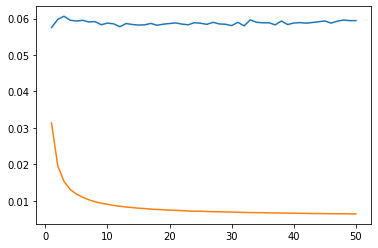

In [0]:
plt.plot(log[['Valid_Loss', 'Train_Loss']])
plt.show()